In [2]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, average_precision_score
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import chisquare
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report
from scipy.stats import ttest_rel


from model import LDM

In [3]:
def create_holdout(Aij, holdout_ratio=0.1, seed=42):
    """
    Creates a holdout set from the given adjacency matrix  by randomly selecting a subset 
    of entries. These selected entries are then masked (set to zero) in the training matrix `Aij_train`, 
    simulating missing interactions for evaluation purposes.

    Parameters:
    -----------
    Aij : torch.Tensor
        The original adjacency matrix representing interactions or link frequencies .
    
    holdout_ratio : float, optional (default=0.1)
        The proportion of positive and negative entries to hold out for evaluation.
    
    seed : int or None, optional (default=42)
        Random seed for reproducibility. Set to `None` to disable fixed randomness.

    Returns:
    --------
    Aij_train : torch.Tensor
        A copy of the original adjacency matrix with the holdout entries set to zero, 
        to be used for training.

    holdouts : list of tuple
        A list of index tuples `(i, j)` corresponding to the entries that were held out
    """
    Aij_train = Aij.clone()
    if seed is not None:
        random.seed(seed)

    Aij_np = Aij.cpu().numpy()
    pos_cases = [(i,j) for i in range(Aij_np.shape[0]) for j in range(Aij_np.shape[1]) if Aij_np[i,j] > 0]
    neg_cases = [(i,j) for i in range(Aij_np.shape[0]) for j in range(Aij_np.shape[1]) if Aij_np[i,j]==0]

    # select holdtout cases randomly
    n_holdout_pos = int(len(pos_cases)*holdout_ratio)
    n_holdout_neg = int(len(neg_cases)*holdout_ratio)

    holdout_pos = random.sample(pos_cases, n_holdout_pos)
    holdout_neg = random.sample(neg_cases, n_holdout_neg)

    holdouts = holdout_pos + holdout_neg
    random.shuffle(holdouts)
    for i, j in holdouts:
        Aij_train[i,j]=0.0
    return Aij_train, holdouts

In [4]:
class ModelEvaluate:
    """
    Inputs:
    ---------
    - model: A trained Latent Distance Model

    - Aij_true: Ground-truth PyTorch tensor of shape (n_drugs, n_effects)

    Function explanations:
    ---------

    - _get_predictions(): Runs the model in eval mode and returns both class predictions and class probabilities as NumPy arrays.

    - _get_predictions_bin(): Binarizes predictions — class 0 becomes 0; all others become 1.

    - _get_true_values(): Returns the true values as a NumPy array.

    - _get_true_values_bin(): Converts true labels to binary — class 0 becomes 0; others become 1.

    - _get_true_probs(): Returns one-hot encoded ground truth labels as a tensor of shape (n_classes, n_drugs, n_effects).

    - evaluate_binary(): Computes AUC-ROC and AUC-PR for binary classification (non-zero vs. zero).

    - evaluate_class1(), evaluate_class2(), evaluate_class3(): Each evaluates performance (AUC-ROC, AUC-PR) for a specific class (1, 2, or 3) vs. the rest.

    - NMI_basic(): Calculates Normalized Mutual Information (NMI) between predicted and true class labels using their joint distribution.

    - NMI_advanced(): Computes NMI using soft probabilistic class distributions (from both model and ground truth one-hot), capturing uncertainty.

    - plot_confusion(): Displays a heatmap confusion matrix and classification report using predicted and true labels.
    """

    def __init__(self, model, Aij_true, test_indices=None):
        self.model = model
        self.Aij_true = Aij_true
        self.test_indices = test_indices

        self.n_drugs, self.n_effects = Aij_true.shape
        self.n_ordinal_classes = Aij_true.max().int().item() +1

    def _get_predictions(self):
        self.model.eval_mode = True
        with torch.no_grad():
            preds, probs = self.model.predict_categories()
            preds_np = preds.cpu().numpy()
            probs_np = probs.cpu().numpy()
        return preds_np, probs_np

    def _get_predictions_bin(self):
        preds_np, _ = self._get_predictions()
        preds_np_bin = np.where(preds_np > 0, 1, 0)
        return preds_np_bin

    def _get_true_values(self):
        Aij_true_np = self.Aij_true.detach().cpu().numpy()
        return Aij_true_np
    
    def _get_true_values_bin(self):
        Aij_np_bin = self._get_true_values()
        Aij_np_bin = np.where(Aij_np_bin > 0, 1, 0)
        return Aij_np_bin

    def _get_true_probs(self):
        Aij_true = self.Aij_true
        n_drugs, n_effects = Aij_true.shape
        n_ordinal_classes = Aij_true.max().int().item() +1
        Aij_true_flat = Aij_true.clone().reshape(-1)
        Aij_true_flat = F.one_hot(Aij_true_flat.long(), n_ordinal_classes)
        Aij_true_probs = Aij_true_flat.view(n_drugs, n_effects, n_ordinal_classes).permute(2, 0, 1)
        return Aij_true_probs

    def evaluate_binary(self):
        preds_np = self._get_predictions_bin()
        true_np = self._get_true_values_bin()

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true_np[i, j])
                pred_vals.append(preds_np[i, j])
        else:
            for i in range(true_np.shape[0]):
                for j in range(true_np.shape[1]):
                    true_vals.append(true_np[i, j])
                    pred_vals.append(preds_np[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr
    
    def evaluate_class1(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()
        preds1 = np.where(preds == 1, 1, 0)
        true1 = np.where(true == 1, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true1[i, j])
                pred_vals.append(preds1[i, j])
        else:
            for i in range(true1.shape[0]):
                for j in range(true1.shape[1]):
                    true_vals.append(true1[i, j])
                    pred_vals.append(preds1[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr

    def evaluate_class2(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()
        preds2 = np.where(preds == 2, 1, 0)
        true2 = np.where(true == 2, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true2[i, j])
                pred_vals.append(preds2[i, j])
        else:
            for i in range(true2.shape[0]):
                for j in range(true2.shape[1]):
                    true_vals.append(true2[i, j])
                    pred_vals.append(preds2[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr
    
    def evaluate_class3(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()
        preds3 = np.where(preds == 3, 1, 0)
        true3 = np.where(true == 3, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true3[i, j])
                pred_vals.append(preds3[i, j])
        else:
            for i in range(true3.shape[0]):
                for j in range(true3.shape[1]):
                    true_vals.append(true3[i, j])
                    pred_vals.append(preds3[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr

    def NMI_basic(self):
        Aij_pred, _ = self._get_predictions()
        Aij_true = self._get_true_values()
        #compute edges
        edges = torch.nonzero(torch.tensor(Aij_true) >= 0, as_tuple=False)

        true_labels = []
        pred_labels = []
        for i, j in edges:
            true_labels.append(Aij_true[i,j])
            pred_labels.append(Aij_pred[i,j])
        
        #P(c|c')
        #joint distribution (when are entries in Aij_true and Aij_pred equal)
        n_classes = int(Aij_true.max().item()+1)
        joint_counts = np.zeros((n_classes, n_classes))

        for c, c_mark in zip(true_labels, pred_labels):
            joint_counts[int(c), int(c_mark)] += 1
        joint_probs = joint_counts/ joint_counts.sum()

        #P(c) and P(c')
        p_c = np.sum(joint_probs, axis=1)
        p_c_mark = np.sum(joint_probs, axis=0)

        # Compute entropy (H(c)) and H(c'))
        H_c = -np.sum(p_c * np.log(p_c + 1e-8))
        H_c_mark = -np.sum(p_c_mark *np.log(p_c_mark + 1e-8))

        #Compute mutual information
        MI = 0
        for c in range(n_classes):
            for c_mark in range(n_classes):
                if joint_probs[c, c_mark] > 0:
                    MI += joint_probs[c, c_mark] * np.log(joint_probs[c, c_mark] / (p_c[c] * p_c_mark[c_mark]))

        # Compute NMI
        NMI = 2*MI/(H_c + H_c_mark)
    
        return NMI, joint_probs
    
    def NMI_advanced(self):
        """ 
        Should run two models e.g one with holdout and one without. Input is the probabilities of each entry being in each class (e.i. the probit matrix)
        """
        _, probs = self._get_predictions()
        Aij_true_probs = self._get_true_probs()
        Aij_probs = Aij_true_probs.detach().cpu().numpy()

        joint_probs = np.zeros((self.n_ordinal_classes, self.n_ordinal_classes))

        for i in range(self.n_drugs):
            for j in range(self.n_effects):
                joint_probs += np.outer(Aij_probs[:, i, j], probs[:, i, j])
                
        joint_probs /= (self.n_drugs*self.n_effects)

        joint_true = np.zeros((self.n_ordinal_classes, self.n_ordinal_classes))
        joint_pred = np.zeros((self.n_ordinal_classes, self.n_ordinal_classes))

        for i in range(self.n_drugs):
             for j in range(self.n_effects):
                  joint_true += np.outer(Aij_probs[:, i, j], Aij_probs[:, i, j])
                  joint_pred += np.outer(probs[:, i, j], probs[:, i, j])

        joint_true /= (self.n_drugs * self.n_effects)
        joint_pred /= (self.n_drugs * self.n_effects)

        # Compute entropy (H(c)) and H(c'))
        H_c = -np.sum(joint_true * np.log(joint_true + 1e-8))
        H_c_mark = -np.sum(joint_pred *np.log(joint_pred + 1e-8))

        #Compute mutual information
        MI = 0
        for c in range(self.n_ordinal_classes):
            for c_mark in range(self.n_ordinal_classes):
                if joint_probs[c, c_mark] > 0:
                    MI += joint_probs[c, c_mark] * np.log(joint_probs[c, c_mark] / (joint_true[c] * joint_pred[c_mark]))

        # Compute NMI
        NMI = 2*MI/(H_c + H_c_mark)
        #kald som mutual information til sig selv
        return NMI, joint_probs


    def plot_confusion(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()
        
        # Flatten inputs
        preds_flat = preds.flatten()
        true_flat = true.flatten()
        
        labels = [0, 1, 2, 3]
        cm = confusion_matrix(true_flat, preds_flat, labels=labels)
        
        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r', xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Ordinal Class Confusion Matrix")
        plt.show()
        
        # Calculate and print metrics
        print("\nClassification Report:")
        print(classification_report(true_flat, preds_flat, labels=labels, digits=3))

        # Optional: calculate and display accuracy per class
        total_samples = len(true_flat)
        print("Accuracy per class:")
        for i in labels:
            class_mask = true_flat == i
            class_acc = (preds_flat[class_mask] == i).sum() / class_mask.sum() if class_mask.sum() > 0 else 0.0
            print(f"Class {i}: {class_acc:.3f}")

    def plot_confusion_percent(self):
        preds,_ = self._get_predictions()#.round().astype(int).flatten()
        true = self._get_true_values()#.flatten()
        cm = confusion_matrix(true.flatten(), preds.flatten(), labels=[0, 1, 2, 3])
        cm_row_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_row_percent, annot=True, cmap='rocket_r')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Ordinal Class Confusion Matrix")
        plt.show()

    def plot_class_distribution(self, plot=True):
        true_flat = self._get_true_values().flatten()
        pred, _ = self._get_predictions()
        pred_flat = pred.flatten()

        # Get union of all classes
        all_classes = np.unique(np.concatenate([true_flat, pred_flat]))

        true_counts = {c: np.sum(true_flat == c) for c in all_classes}
        pred_counts = {c: np.sum(pred_flat == c) for c in all_classes}

        total_true = sum(true_counts.values())
        total_pred = sum(pred_counts.values())

        true_probs = {c: true_counts[c] / total_true for c in all_classes}
        pred_probs = {c: pred_counts[c] / total_pred for c in all_classes}

        if plot:
            x = np.arange(len(all_classes))
            true_vals = [true_probs.get(c, 0) for c in all_classes]
            pred_vals = [pred_probs.get(c, 0) for c in all_classes]

            bar_width = 0.35

            fig, ax = plt.subplots(figsize=(8, 5))
            ax.bar(x - bar_width/2, true_vals, width=bar_width, label='True', alpha=0.8)
            ax.bar(x + bar_width/2, pred_vals, width=bar_width, label='Predicted', alpha=0.8)

            ax.set_xticks(x)
            ax.set_xticklabels([str(int(c)) for c in all_classes])
            ax.set_xlabel('Class')
            ax.set_ylabel('Probability')
            ax.set_title('Class Probability Distribution')
            ax.legend()
            ax.grid(axis='y', linestyle='--', alpha=0.5)
            ax.set_ylim(0, 1)
            plt.tight_layout()
            plt.show()

        return {
        "true_probs": true_probs,
        "pred_probs": pred_probs
    }

    def compare_class_distributions(self):
            """
            Compare predicted and true class distributions using chi-square test.

            Returns:
                p_value: p-value from chi-square test
                dicts: (true_probs, pred_probs) as dictionaries
            """
            true_data = self._get_true_values().flatten()
            pred_data, _ = self._get_predictions().flatten()

            # Get aligned class labels
            all_classes = sorted(set(np.unique(true_data)).union(np.unique(pred_data)))

            # Count frequencies for both
            true_counts = np.array([np.sum(true_data == c) for c in all_classes])
            pred_counts = np.array([np.sum(pred_data == c) for c in all_classes])

            # Chi-square test
            chi2_stat, p_value = chisquare(f_obs=pred_counts, f_exp=true_counts)

            # Normalize to get probs
            true_probs = {c: true_counts[i]/true_counts.sum() for i, c in enumerate(all_classes)}
            pred_probs = {c: pred_counts[i]/pred_counts.sum() for i, c in enumerate(all_classes)}

            return p_value, true_probs, pred_probs


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch

class BaselineEvaluator:
    def __init__(self, baseline_preds, true_labels):
        """
        Args:
            baseline_preds: (n_drugs, n_effects) torch.Tensor or np.array of predicted labels
            true_labels: (n_drugs, n_effects) torch.Tensor or np.array of true labels
        """
        self.baseline_preds = baseline_preds
        self.true_labels = true_labels

    def _get_predictions(self):
        return self.baseline_preds, None

    def _get_true_values(self):
        return self.true_labels

    def plot_confusion(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()

        # Flatten inputs
        preds_flat = preds.flatten()
        true_flat = true.flatten()

        labels = [0, 1, 2, 3]
        cm = confusion_matrix(true_flat, preds_flat, labels=labels)

        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r', xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Baseline Confusion Matrix")
        plt.show()

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_flat, preds_flat, labels=labels, digits=3))

        # Accuracy per class
        print("Accuracy per class:")
        for i in labels:
            class_mask = true_flat == i
            class_acc = (preds_flat[class_mask] == i).sum() / class_mask.sum() if class_mask.sum() > 0 else 0.0
            print(f"Class {i}: {class_acc:.3f}")


In [5]:
def train_and_evaluate_bin(Aij, embedding_dims, device, holdout_ratio, n_epochs, lr):
    """
    Trains and evaluates a binary(only looking at links vs non-links) Latent Distance Model (LDM) across different embedding dimensions
    using holdout sampling. For each dimension, the model is trained multiple times with
    different random seeds to assess performance stability and robustness.

    Parameters:
    -----------
    Aij : torch.Tensor
        Adjacency matrix representing binary interactions (links vs non-links).
    
    embedding_dims : list of int
        List of latent space dimensions to evaluate.
    
    device : torch.device (computation device)
    
    holdout_ratio : float
        Fraction of observed entries to mask
    
    n_epochs : int
        Number of training epochs.
    
    lr : float
        Learning rate for model training.

    Returns:
    --------
    results : List of tuples, where D is the embedding dimension, and the AUC-ROC and AUC-PR are averaged across trials.
    
    std_aucs : Standard deviations of the AUC-ROC scores across 10 runs for each dimension.
    
    std_prs : Standard deviations of the AUC-PR scores across 10 runs for each dimension.
    """
    results = []

    # Store standard deviations
    std_aucs = []
    std_prs = []
    for D in embedding_dims:
        print(f'Embedding dim {D}/', len(embedding_dims))
        auc_rocs = []
        auc_prs = []
        for i in range(10): 
            Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=holdout_ratio, seed = i)
            #Aij_train = Aij
            model = LDM(Aij_train, embedding_dim=D, device=device, n_epochs=n_epochs, lr=lr, seed=i)
            model.train()
            
            evaluator = ModelEvaluate(model, Aij)
            auc_roc, auc_pr = evaluator.evaluate_class1()
            auc_rocs.append(auc_roc)
            auc_prs.append(auc_pr)
            print(f'Iteration {i}/10')
        std_auc_roc = np.std(auc_rocs)
        std_auc_pr = np.std(auc_prs)
        results.append((D, np.mean(auc_rocs), np.mean(auc_prs)))
        std_aucs.append(std_auc_roc)
        std_prs.append(std_auc_pr)
        print(f"D={D} | MEAN-AUC-ROC: {np.mean(auc_rocs):.3f} ± {std_auc_roc:.3f} | MEAN-AUC-PR: {np.mean(auc_prs):.3f} ± {std_auc_pr:.3f}")

    return results, std_aucs, std_prs
    
def plot_auc(results, std_aucs, std_prs):
    dims, auc_rocs, auc_prs = zip(*results)

    plt.figure(figsize=(10, 5))
    plt.errorbar(dims, auc_rocs, yerr=std_aucs, label='AUC-ROC', marker='o', capsize=5)
    plt.errorbar(dims, auc_prs, yerr=std_prs, label='AUC-PR', marker='s', capsize=5)
    plt.xlabel("Latent Dimension (D)")
    plt.ylabel("Score")
    plt.title("Model Performance vs Latent Dimension")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
def train_and_evaluate_simple(Aij, embedding_dims, device, holdout_ratio, n_epochs, lr, classes=[0, 1, 2, 3]):
    """
    Trains and evaluates a Latent Distance Model (LDM) on ordinal classification tasks,
    computing class-wise prediction accuracies for different embedding dimensions.

    Parameters:
    -----------
    Aij :Input matrix containing ordinal labels.
    
    embedding_dims : List of latent space dimensions to evaluate.
    
    device : Computation device (e.g., 'cpu' or 'cuda').
    
    holdout_ratio : float
        Unused in this function (included for interface consistency); holdout masking is currently disabled.
    
    n_epochs : int - number of training epochs for each model instance.
    
    lr : Learning rate used during model training.
    
    classes : List of ordinal categories. Default is [0, 1, 2, 3].

    Returns:
    --------
    results : tuple containing the embedding dimension and a dictionary mapping class labels to mean accuracies.
    
    class_acc_dict : dictionary where each key is a class label and the value is a list of mean accuracies across
        embedding dimensions.

    """
    results = []
    class_acc_dict = {c: [] for c in classes}

    for D in embedding_dims:
        all_class_acc = {c: [] for c in classes}

        for i in range(10): 
            #Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=holdout_ratio, seed=i)
            model = LDM(Aij, embedding_dim=D, device=device, n_epochs=n_epochs, lr=lr, seed=i)
            model.train()

            evaluator = ModelEvaluate(model, Aij)
            preds, _ = evaluator._get_predictions()
            true = evaluator._get_true_values()

            class_stats = {c: {'correct': 0, 'total': 0} for c in classes}

            for x in range(preds.shape[0]):
                for y in range(preds.shape[1]):
                    pred_val = preds[x, y]
                    true_val = true[x, y]
                    if pred_val in classes:
                        if pred_val == true_val:
                            class_stats[pred_val]['correct'] += 1
                        class_stats[pred_val]['total'] += 1

            for c in classes:
                correct = class_stats[c]['correct']
                total = class_stats[c]['total']
                acc = correct / total if total > 0 else 0
                all_class_acc[c].append(acc)

        # Mean accuracy across seeds for each class
        for c in classes:
            class_acc_dict[c].append(np.mean(all_class_acc[c]))

        results.append((D, {c: np.mean(all_class_acc[c]) for c in classes}))

    return results, class_acc_dict
    
def plot_class_accuracy(embedding_dims, acc_dict):
    for c in acc_dict:
        plt.plot(embedding_dims, acc_dict[c], marker='o', label=f"Class {c}")

    plt.xlabel("Embedding Dimension")
    plt.ylabel("Mean Accuracy")
    plt.title("Accuracy per Class vs Embedding Dimension")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
def NMI_advanced(Aij_probs_true, Aij_probs_pred):
        """
    Computes the Normalized Mutual Information (NMI) between two probit matrix stored in tensors between runs for two models.

    Parameters:
    -----------
    Aij_probs_true : torch.Tensor
        A 3D tensor of shape (C, N, M) representing the predicted probability distributions over `C` ordinal classes
        for each drug-side effect pair
    
    Aij_probs_pred : torch.Tensor
        A 3D tensor of shape (C, N, M) representing the predicted probability distributions over `C` ordinal classes
        for each drug-side effect pair

    Returns:
    --------
    NMI : float
        The Normalized Mutual Information between the two probit-matrices. This score quantifies the
        mutual dependence between the two distributions, normalized by their entropies.
    
    joint_probs : np.ndarray
        A 2D array of shape (C, C) representing the joint probability matrix between the class predictions
        from the two models.
        """
        Aij_probs_true = Aij_probs_true.detach().cpu().numpy()
        Aij_probs_pred = Aij_probs_pred.detach().cpu().numpy()
        n_ordinal_classes, n_drugs, n_effects = Aij_probs_true.shape

        joint_probs = np.zeros((n_ordinal_classes, n_ordinal_classes))

        for i in range(n_drugs):
            for j in range(n_effects):
                joint_probs += np.outer(Aij_probs_true[:, i, j], Aij_probs_pred[:, i, j])
                
        joint_probs /= (n_drugs*n_effects)

        joint_true = np.zeros((n_ordinal_classes, n_ordinal_classes))
        joint_pred = np.zeros((n_ordinal_classes, n_ordinal_classes))

        for i in range(n_drugs):
             for j in range(n_effects):
                  joint_true += np.outer(Aij_probs_true[:, i, j], Aij_probs_true[:, i, j])
                  joint_pred += np.outer(Aij_probs_pred[:, i, j], Aij_probs_pred[:, i, j])

        joint_true /= (n_drugs * n_effects)
        joint_pred /= (n_drugs * n_effects)

        p_c = np.sum(joint_probs, axis=1)       # shape (n_classes,)
        p_c_mark = np.sum(joint_probs, axis=0)  # shape (n_classes,)

        # Compute entropy
        H_c = -np.sum(p_c * np.log(p_c + 1e-8))
        H_c_mark = -np.sum(p_c_mark * np.log(p_c_mark + 1e-8))

        # Compute mutual information
        MI = 0
        for c in range(n_ordinal_classes):
            for c_mark in range(n_ordinal_classes):
                if joint_probs[c, c_mark] > 0:
                    MI += joint_probs[c, c_mark] * np.log(joint_probs[c, c_mark] / (p_c[c] * p_c_mark[c_mark]))

        # Compute NMI
        NMI = 2 * MI / (H_c + H_c_mark + 1e-8)

        return NMI, joint_probs

In [7]:
def test_embedding_dims(Aij, embedding_dims, device, holdout_ratio, n_epochs, lr):
    results = []
    std_NMIs = []

    for D in embedding_dims:
        NMIs = []
        for i in range(10):
            Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=holdout_ratio, seed=i)
            model = LDM(Aij_train, embedding_dim=D, device=device, n_epochs=n_epochs, lr=lr, seed=i)
            model.train()

            evaluator = ModelEvaluate(model, Aij)
            Aij_probs_pred = evaluator._get_predictions()[1]
            Aij_probs_true = evaluator._get_true_probs()

            NMI, _ = NMI_advanced(Aij_probs_true, Aij_probs_pred)
            NMIs.append(NMI)
            print(f'Iteration {i}/10')

        mean_NMI = np.mean(NMI)
        std_NMI = np.std(NMI)
        results.append((D, mean_NMI))
        std_NMIs.append(std_NMI)

        print(f"D={D} | MEAN-NMI: {mean_NMI:.4f} ± {std_NMI:.4f}")
    return results, std_NMIs

In [31]:
def get_class_distribution(Aij_train, num_classes):
    """
    Aij_train: (n_drugs, n_effects) 
    """
    Aij_train = Aij_train.detach().cpu().numpy()
    counts = np.zeros(num_classes)
    for k in range(num_classes):
        counts[k] = np.sum(Aij_train == k)
    probs = counts / np.sum(counts)
    return probs 

def baseline(shape, class_probs):
    """
    shape: (n_drugs, n_effects)
    class_probs: (num_classes,)  distribution of classes
    Returns:
        baseline_probs: (num_classes, n_drugs, n_effects)
    """
    num_classes = len(class_probs)
    n_drugs, n_effects = shape
    baseline_probs = np.zeros((num_classes, n_drugs, n_effects))
    for c in range(num_classes):
        baseline_probs[c, :, :] = class_probs[c]
    return baseline_probs

def baseline_predictions(prob_matrix):
    """
    Convert baseline probability predictions to hard class predictions using argmax (as in LDM).
    
    Args:
        prob_matrix (torch.Tensor): Shape (n_classes, n_drugs, n_effects)
    
    Returns:
        torch.Tensor: Shape (n_drugs, n_effects), with class labels
    """
    if isinstance(prob_matrix, np.ndarray):
        prob_matrix = torch.tensor(prob_matrix)
    return torch.argmax(prob_matrix, dim=0)


## Loading the data

In [8]:
#real data
def load_data(path_to_csv, device):
    df = pd.read_csv(path_to_csv, index_col=0)
    Aij = torch.tensor(df.values, dtype=torch.float32).to(device)
    return Aij

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = "/Users/christine/LatentDistanceModel/data/filtered_adj_matrix.csv" 
Aij_real = load_data(csv_path, device)
print(Aij_real.shape)

torch.Size([745, 3677])


## Baseline model

In [27]:
Aij_train, _ = create_holdout(Aij_real, holdout_ratio=0.1, seed=42)
class_probs = get_class_distribution(Aij_train, num_classes=4)

baseline_out = baseline(Aij_real.shape, class_probs)

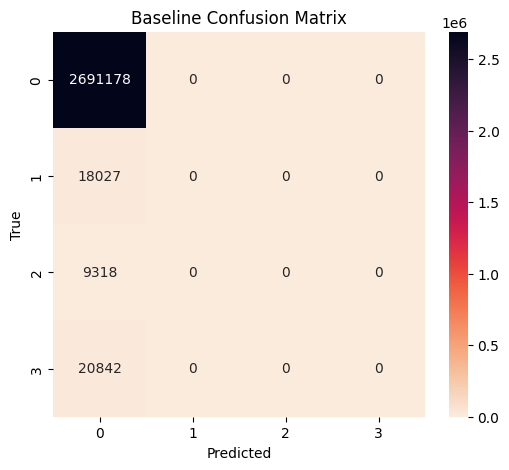


Classification Report:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0      0.982     1.000     0.991   2691178
           1      0.000     0.000     0.000     18027
           2      0.000     0.000     0.000      9318
           3      0.000     0.000     0.000     20842

    accuracy                          0.982   2739365
   macro avg      0.246     0.250     0.248   2739365
weighted avg      0.965     0.982     0.974   2739365

Accuracy per class:
Class 0: 1.000
Class 1: 0.000
Class 2: 0.000
Class 3: 0.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
baseline_probs = baseline(Aij_real.shape, class_probs)  # shape: (n_classes, n_drugs, n_effects)
baseline_preds = baseline_predictions(baseline_probs)               # shape: (n_drugs, n_effects)

# True labels
true_labels = Aij_train if isinstance(Aij_train, torch.Tensor) else torch.tensor(Aij_train)

# Plot confusion matrix
baseline_eval = BaselineEvaluator(baseline_preds, true_labels)
baseline_eval.plot_confusion()

## Training Latent Distance Model

In [18]:
embedding_dims = [2, 5, 10, 15, 30]
holdout_ratio = 0.1
n_epochs = 100
lr = 0.005
results, std_aucs, std_prs = train_and_evaluate_bin(Aij_real, embedding_dims, device, holdout_ratio, n_epochs, lr)
plot_auc(results, std_aucs, std_prs)

Embedding dim 2/ 5


/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/100, Loss: 0.0901
Epoch 1/100, Loss: 0.0888
Epoch 2/100, Loss: 0.0880
Epoch 3/100, Loss: 0.0873
Epoch 4/100, Loss: 0.0868
Epoch 5/100, Loss: 0.0860
Epoch 6/100, Loss: 0.0854
Epoch 7/100, Loss: 0.0848
Epoch 8/100, Loss: 0.0843
Epoch 9/100, Loss: 0.0840
Epoch 10/100, Loss: 0.0837
Epoch 11/100, Loss: 0.0835
Epoch 12/100, Loss: 0.0832
Epoch 13/100, Loss: 0.0829
Epoch 14/100, Loss: 0.0826
Epoch 15/100, Loss: 0.0824
Epoch 16/100, Loss: 0.0821
Epoch 17/100, Loss: 0.0819
Epoch 18/100, Loss: 0.0817
Epoch 19/100, Loss: 0.0815
Epoch 20/100, Loss: 0.0813
Epoch 21/100, Loss: 0.0811
Epoch 22/100, Loss: 0.0809
Epoch 23/100, Loss: 0.0807
Epoch 24/100, Loss: 0.0805
Epoch 25/100, Loss: 0.0803
Epoch 26/100, Loss: 0.0802
Epoch 27/100, Loss: 0.0800
Epoch 28/100, Loss: 0.0798
Epoch 29/100, Loss: 0.0796
Epoch 30/100, Loss: 0.0794
Epoch 31/100, Loss: 0.0792
Epoch 32/100, Loss: 0.0790
Epoch 33/100, Loss: 0.0788
Epoch 34/100, Loss: 0.0787
Epoch 35/100, Loss: 0.0785
Epoch 36/100, Loss: 0.0784
Epoch 37/10

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/100, Loss: 0.0882
Epoch 1/100, Loss: 0.0864
Epoch 2/100, Loss: 0.0860
Epoch 3/100, Loss: 0.0851
Epoch 4/100, Loss: 0.0843
Epoch 5/100, Loss: 0.0840
Epoch 6/100, Loss: 0.0837
Epoch 7/100, Loss: 0.0830
Epoch 8/100, Loss: 0.0822
Epoch 9/100, Loss: 0.0818
Epoch 10/100, Loss: 0.0815
Epoch 11/100, Loss: 0.0810
Epoch 12/100, Loss: 0.0805
Epoch 13/100, Loss: 0.0801
Epoch 14/100, Loss: 0.0799
Epoch 15/100, Loss: 0.0795
Epoch 16/100, Loss: 0.0790
Epoch 17/100, Loss: 0.0785
Epoch 18/100, Loss: 0.0781
Epoch 19/100, Loss: 0.0778
Epoch 20/100, Loss: 0.0775
Epoch 21/100, Loss: 0.0772
Epoch 22/100, Loss: 0.0770
Epoch 23/100, Loss: 0.0768
Epoch 24/100, Loss: 0.0766
Epoch 25/100, Loss: 0.0763
Epoch 26/100, Loss: 0.0762
Epoch 27/100, Loss: 0.0760
Epoch 28/100, Loss: 0.0759
Epoch 29/100, Loss: 0.0757
Epoch 30/100, Loss: 0.0755
Epoch 31/100, Loss: 0.0754
Epoch 32/100, Loss: 0.0752
Epoch 33/100, Loss: 0.0750
Epoch 34/100, Loss: 0.0749
Epoch 35/100, Loss: 0.0747
Epoch 36/100, Loss: 0.0746
Epoch 37/10

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/100, Loss: 0.0986
Epoch 1/100, Loss: 0.0972
Epoch 2/100, Loss: 0.0964
Epoch 3/100, Loss: 0.0958
Epoch 4/100, Loss: 0.0951
Epoch 5/100, Loss: 0.0943
Epoch 6/100, Loss: 0.0936
Epoch 7/100, Loss: 0.0929
Epoch 8/100, Loss: 0.0924
Epoch 9/100, Loss: 0.0919
Epoch 10/100, Loss: 0.0914
Epoch 11/100, Loss: 0.0908
Epoch 12/100, Loss: 0.0903
Epoch 13/100, Loss: 0.0899
Epoch 14/100, Loss: 0.0895
Epoch 15/100, Loss: 0.0891
Epoch 16/100, Loss: 0.0887
Epoch 17/100, Loss: 0.0883
Epoch 18/100, Loss: 0.0879
Epoch 19/100, Loss: 0.0876
Epoch 20/100, Loss: 0.0873
Epoch 21/100, Loss: 0.0869
Epoch 22/100, Loss: 0.0865
Epoch 23/100, Loss: 0.0862
Epoch 24/100, Loss: 0.0858
Epoch 25/100, Loss: 0.0855
Epoch 26/100, Loss: 0.0851
Epoch 27/100, Loss: 0.0847
Epoch 28/100, Loss: 0.0844
Epoch 29/100, Loss: 0.0840
Epoch 30/100, Loss: 0.0837
Epoch 31/100, Loss: 0.0834
Epoch 32/100, Loss: 0.0831
Epoch 33/100, Loss: 0.0829
Epoch 34/100, Loss: 0.0826
Epoch 35/100, Loss: 0.0823
Epoch 36/100, Loss: 0.0821
Epoch 37/10

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/100, Loss: 0.0927
Epoch 1/100, Loss: 0.0904
Epoch 2/100, Loss: 0.0889
Epoch 3/100, Loss: 0.0881
Epoch 4/100, Loss: 0.0874
Epoch 5/100, Loss: 0.0866
Epoch 6/100, Loss: 0.0859
Epoch 7/100, Loss: 0.0852
Epoch 8/100, Loss: 0.0846
Epoch 9/100, Loss: 0.0841
Epoch 10/100, Loss: 0.0837
Epoch 11/100, Loss: 0.0834
Epoch 12/100, Loss: 0.0830
Epoch 13/100, Loss: 0.0827
Epoch 14/100, Loss: 0.0824
Epoch 15/100, Loss: 0.0821
Epoch 16/100, Loss: 0.0817
Epoch 17/100, Loss: 0.0813
Epoch 18/100, Loss: 0.0810
Epoch 19/100, Loss: 0.0806
Epoch 20/100, Loss: 0.0802
Epoch 21/100, Loss: 0.0797
Epoch 22/100, Loss: 0.0792
Epoch 23/100, Loss: 0.0787
Epoch 24/100, Loss: 0.0782
Epoch 25/100, Loss: 0.0779
Epoch 26/100, Loss: 0.0776
Epoch 27/100, Loss: 0.0774
Epoch 28/100, Loss: 0.0771
Epoch 29/100, Loss: 0.0769
Epoch 30/100, Loss: 0.0767
Epoch 31/100, Loss: 0.0764
Epoch 32/100, Loss: 0.0762
Epoch 33/100, Loss: 0.0759
Epoch 34/100, Loss: 0.0757
Epoch 35/100, Loss: 0.0755
Epoch 36/100, Loss: 0.0753
Epoch 37/10

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/100, Loss: 0.0917
Epoch 1/100, Loss: 0.0908
Epoch 2/100, Loss: 0.0902
Epoch 3/100, Loss: 0.0897
Epoch 4/100, Loss: 0.0891
Epoch 5/100, Loss: 0.0886
Epoch 6/100, Loss: 0.0882
Epoch 7/100, Loss: 0.0878
Epoch 8/100, Loss: 0.0874
Epoch 9/100, Loss: 0.0871
Epoch 10/100, Loss: 0.0869
Epoch 11/100, Loss: 0.0866
Epoch 12/100, Loss: 0.0862
Epoch 13/100, Loss: 0.0860
Epoch 14/100, Loss: 0.0857
Epoch 15/100, Loss: 0.0855
Epoch 16/100, Loss: 0.0853
Epoch 17/100, Loss: 0.0850
Epoch 18/100, Loss: 0.0849
Epoch 19/100, Loss: 0.0847
Epoch 20/100, Loss: 0.0845
Epoch 21/100, Loss: 0.0843
Epoch 22/100, Loss: 0.0841
Epoch 23/100, Loss: 0.0840
Epoch 24/100, Loss: 0.0839
Epoch 25/100, Loss: 0.0838
Epoch 26/100, Loss: 0.0837
Epoch 27/100, Loss: 0.0836
Epoch 28/100, Loss: 0.0835
Epoch 29/100, Loss: 0.0834
Epoch 30/100, Loss: 0.0832
Epoch 31/100, Loss: 0.0830
Epoch 32/100, Loss: 0.0829
Epoch 33/100, Loss: 0.0827
Epoch 34/100, Loss: 0.0826
Epoch 35/100, Loss: 0.0824
Epoch 36/100, Loss: 0.0823
Epoch 37/10

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/100, Loss: 0.1030
Epoch 1/100, Loss: 0.1017
Epoch 2/100, Loss: 0.1009
Epoch 3/100, Loss: 0.1001
Epoch 4/100, Loss: 0.0993
Epoch 5/100, Loss: 0.0985
Epoch 6/100, Loss: 0.0979
Epoch 7/100, Loss: 0.0973
Epoch 8/100, Loss: 0.0967
Epoch 9/100, Loss: 0.0961
Epoch 10/100, Loss: 0.0956
Epoch 11/100, Loss: 0.0951
Epoch 12/100, Loss: 0.0946
Epoch 13/100, Loss: 0.0942
Epoch 14/100, Loss: 0.0937
Epoch 15/100, Loss: 0.0933
Epoch 16/100, Loss: 0.0930
Epoch 17/100, Loss: 0.0925
Epoch 18/100, Loss: 0.0921
Epoch 19/100, Loss: 0.0915
Epoch 20/100, Loss: 0.0910
Epoch 21/100, Loss: 0.0905
Epoch 22/100, Loss: 0.0900
Epoch 23/100, Loss: 0.0895
Epoch 24/100, Loss: 0.0891
Epoch 25/100, Loss: 0.0887
Epoch 26/100, Loss: 0.0883
Epoch 27/100, Loss: 0.0880
Epoch 28/100, Loss: 0.0876
Epoch 29/100, Loss: 0.0873
Epoch 30/100, Loss: 0.0870
Epoch 31/100, Loss: 0.0867
Epoch 32/100, Loss: 0.0864
Epoch 33/100, Loss: 0.0861
Epoch 34/100, Loss: 0.0858
Epoch 35/100, Loss: 0.0855
Epoch 36/100, Loss: 0.0852
Epoch 37/10

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/100, Loss: 0.0959
Epoch 1/100, Loss: 0.0949
Epoch 2/100, Loss: 0.0938
Epoch 3/100, Loss: 0.0927
Epoch 4/100, Loss: 0.0918
Epoch 5/100, Loss: 0.0910
Epoch 6/100, Loss: 0.0904
Epoch 7/100, Loss: 0.0899
Epoch 8/100, Loss: 0.0895
Epoch 9/100, Loss: 0.0891
Epoch 10/100, Loss: 0.0888
Epoch 11/100, Loss: 0.0884
Epoch 12/100, Loss: 0.0880
Epoch 13/100, Loss: 0.0876
Epoch 14/100, Loss: 0.0872
Epoch 15/100, Loss: 0.0868
Epoch 16/100, Loss: 0.0863
Epoch 17/100, Loss: 0.0859
Epoch 18/100, Loss: 0.0855
Epoch 19/100, Loss: 0.0851
Epoch 20/100, Loss: 0.0848
Epoch 21/100, Loss: 0.0844
Epoch 22/100, Loss: 0.0841
Epoch 23/100, Loss: 0.0838


KeyboardInterrupt: 

In [13]:
embedding_dims = [2, 5, 10, 15, 30]
holdout_ratio = 0.1
n_epochs = 200
lr = 0.01
results, std_aucs, std_prs = train_and_evaluate_bin(Aij_real, embedding_dims, device, holdout_ratio, n_epochs, lr)

Embedding dim 2/ 5


/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 5.2555
Epoch 1/200, Loss: 4.7860
Epoch 2/200, Loss: 4.3995
Epoch 3/200, Loss: 4.0564
Epoch 4/200, Loss: 3.7845
Epoch 5/200, Loss: 3.5090
Epoch 6/200, Loss: 3.2525
Epoch 7/200, Loss: 3.0324
Epoch 8/200, Loss: 2.8218
Epoch 9/200, Loss: 2.6534
Epoch 10/200, Loss: 2.5014
Epoch 11/200, Loss: 2.3737
Epoch 12/200, Loss: 2.2612
Epoch 13/200, Loss: 2.1552
Epoch 14/200, Loss: 2.0448
Epoch 15/200, Loss: 1.9305
Epoch 16/200, Loss: 1.8161
Epoch 17/200, Loss: 1.6957
Epoch 18/200, Loss: 1.5864
Epoch 19/200, Loss: 1.4941
Epoch 20/200, Loss: 1.4158
Epoch 21/200, Loss: 1.3406
Epoch 22/200, Loss: 1.2669
Epoch 23/200, Loss: 1.2071
Epoch 24/200, Loss: 1.1595
Epoch 25/200, Loss: 1.1191
Epoch 26/200, Loss: 1.0826
Epoch 27/200, Loss: 1.0485
Epoch 28/200, Loss: 1.0156
Epoch 29/200, Loss: 0.9836
Epoch 30/200, Loss: 0.9521
Epoch 31/200, Loss: 0.9208
Epoch 32/200, Loss: 0.8901
Epoch 33/200, Loss: 0.8607
Epoch 34/200, Loss: 0.8331
Epoch 35/200, Loss: 0.8077
Epoch 36/200, Loss: 0.7841
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 4.4809
Epoch 1/200, Loss: 4.0332
Epoch 2/200, Loss: 3.6111
Epoch 3/200, Loss: 3.2541
Epoch 4/200, Loss: 2.9597
Epoch 5/200, Loss: 2.6690
Epoch 6/200, Loss: 2.3961
Epoch 7/200, Loss: 2.2325
Epoch 8/200, Loss: 2.0585
Epoch 9/200, Loss: 1.8818
Epoch 10/200, Loss: 1.7323
Epoch 11/200, Loss: 1.6064
Epoch 12/200, Loss: 1.4948
Epoch 13/200, Loss: 1.3962
Epoch 14/200, Loss: 1.3081
Epoch 15/200, Loss: 1.2256
Epoch 16/200, Loss: 1.1505
Epoch 17/200, Loss: 1.0866
Epoch 18/200, Loss: 1.0331
Epoch 19/200, Loss: 0.9875
Epoch 20/200, Loss: 0.9431
Epoch 21/200, Loss: 0.8979
Epoch 22/200, Loss: 0.8584
Epoch 23/200, Loss: 0.8262
Epoch 24/200, Loss: 0.8003
Epoch 25/200, Loss: 0.7785
Epoch 26/200, Loss: 0.7598
Epoch 27/200, Loss: 0.7429
Epoch 28/200, Loss: 0.7256
Epoch 29/200, Loss: 0.7061
Epoch 30/200, Loss: 0.6837
Epoch 31/200, Loss: 0.6593
Epoch 32/200, Loss: 0.6347
Epoch 33/200, Loss: 0.6118
Epoch 34/200, Loss: 0.5923
Epoch 35/200, Loss: 0.5761
Epoch 36/200, Loss: 0.5623
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 8.5418
Epoch 1/200, Loss: 7.9885
Epoch 2/200, Loss: 7.4596
Epoch 3/200, Loss: 6.9315
Epoch 4/200, Loss: 6.4412
Epoch 5/200, Loss: 5.9278
Epoch 6/200, Loss: 5.4226
Epoch 7/200, Loss: 4.9892
Epoch 8/200, Loss: 4.6349
Epoch 9/200, Loss: 4.2685
Epoch 10/200, Loss: 3.9276
Epoch 11/200, Loss: 3.5608
Epoch 12/200, Loss: 3.1481
Epoch 13/200, Loss: 2.7753
Epoch 14/200, Loss: 2.4278
Epoch 15/200, Loss: 2.1963
Epoch 16/200, Loss: 2.0310
Epoch 17/200, Loss: 1.8552
Epoch 18/200, Loss: 1.6968
Epoch 19/200, Loss: 1.5685
Epoch 20/200, Loss: 1.4676
Epoch 21/200, Loss: 1.3759
Epoch 22/200, Loss: 1.2931
Epoch 23/200, Loss: 1.2220
Epoch 24/200, Loss: 1.1617
Epoch 25/200, Loss: 1.1085
Epoch 26/200, Loss: 1.0584
Epoch 27/200, Loss: 1.0095
Epoch 28/200, Loss: 0.9624
Epoch 29/200, Loss: 0.9182
Epoch 30/200, Loss: 0.8774
Epoch 31/200, Loss: 0.8405
Epoch 32/200, Loss: 0.8071
Epoch 33/200, Loss: 0.7768
Epoch 34/200, Loss: 0.7496
Epoch 35/200, Loss: 0.7245
Epoch 36/200, Loss: 0.7011
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 6.6411
Epoch 1/200, Loss: 6.0182
Epoch 2/200, Loss: 5.4779
Epoch 3/200, Loss: 5.0363
Epoch 4/200, Loss: 4.6238
Epoch 5/200, Loss: 4.2647
Epoch 6/200, Loss: 3.9445
Epoch 7/200, Loss: 3.6468
Epoch 8/200, Loss: 3.3717
Epoch 9/200, Loss: 3.1310
Epoch 10/200, Loss: 2.9264
Epoch 11/200, Loss: 2.7206
Epoch 12/200, Loss: 2.4991
Epoch 13/200, Loss: 2.2873
Epoch 14/200, Loss: 2.0942
Epoch 15/200, Loss: 1.9233
Epoch 16/200, Loss: 1.7772
Epoch 17/200, Loss: 1.6575
Epoch 18/200, Loss: 1.5546
Epoch 19/200, Loss: 1.4674
Epoch 20/200, Loss: 1.3909
Epoch 21/200, Loss: 1.3162
Epoch 22/200, Loss: 1.2405
Epoch 23/200, Loss: 1.1698
Epoch 24/200, Loss: 1.1069
Epoch 25/200, Loss: 1.0509
Epoch 26/200, Loss: 1.0013
Epoch 27/200, Loss: 0.9568
Epoch 28/200, Loss: 0.9177
Epoch 29/200, Loss: 0.8838
Epoch 30/200, Loss: 0.8538
Epoch 31/200, Loss: 0.8255
Epoch 32/200, Loss: 0.7972
Epoch 33/200, Loss: 0.7708
Epoch 34/200, Loss: 0.7480
Epoch 35/200, Loss: 0.7287
Epoch 36/200, Loss: 0.7125
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 2.3236
Epoch 1/200, Loss: 2.1307
Epoch 2/200, Loss: 1.9855
Epoch 3/200, Loss: 1.8698
Epoch 4/200, Loss: 1.7677
Epoch 5/200, Loss: 1.6822
Epoch 6/200, Loss: 1.6068
Epoch 7/200, Loss: 1.5366
Epoch 8/200, Loss: 1.4717
Epoch 9/200, Loss: 1.4077
Epoch 10/200, Loss: 1.3351
Epoch 11/200, Loss: 1.2512
Epoch 12/200, Loss: 1.1587
Epoch 13/200, Loss: 1.0563
Epoch 14/200, Loss: 0.9620
Epoch 15/200, Loss: 0.8827
Epoch 16/200, Loss: 0.8114
Epoch 17/200, Loss: 0.7524
Epoch 18/200, Loss: 0.7048
Epoch 19/200, Loss: 0.6660
Epoch 20/200, Loss: 0.6322
Epoch 21/200, Loss: 0.5995
Epoch 22/200, Loss: 0.5676
Epoch 23/200, Loss: 0.5368
Epoch 24/200, Loss: 0.5079
Epoch 25/200, Loss: 0.4821
Epoch 26/200, Loss: 0.4600
Epoch 27/200, Loss: 0.4404
Epoch 28/200, Loss: 0.4212
Epoch 29/200, Loss: 0.4027
Epoch 30/200, Loss: 0.3877
Epoch 31/200, Loss: 0.3772
Epoch 32/200, Loss: 0.3705
Epoch 33/200, Loss: 0.3662
Epoch 34/200, Loss: 0.3632
Epoch 35/200, Loss: 0.3610
Epoch 36/200, Loss: 0.3593
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 10.1534
Epoch 1/200, Loss: 9.6932
Epoch 2/200, Loss: 9.1762
Epoch 3/200, Loss: 8.6342
Epoch 4/200, Loss: 8.0912
Epoch 5/200, Loss: 7.4634
Epoch 6/200, Loss: 6.7923
Epoch 7/200, Loss: 6.1116
Epoch 8/200, Loss: 5.5942
Epoch 9/200, Loss: 5.2040
Epoch 10/200, Loss: 4.8271
Epoch 11/200, Loss: 4.5183
Epoch 12/200, Loss: 4.2226
Epoch 13/200, Loss: 3.9656
Epoch 14/200, Loss: 3.7008
Epoch 15/200, Loss: 3.4279
Epoch 16/200, Loss: 3.2038
Epoch 17/200, Loss: 3.0120
Epoch 18/200, Loss: 2.8499
Epoch 19/200, Loss: 2.6450
Epoch 20/200, Loss: 2.4328
Epoch 21/200, Loss: 2.2437
Epoch 22/200, Loss: 2.0836
Epoch 23/200, Loss: 1.9454
Epoch 24/200, Loss: 1.8202
Epoch 25/200, Loss: 1.7050
Epoch 26/200, Loss: 1.6030
Epoch 27/200, Loss: 1.5122
Epoch 28/200, Loss: 1.4279
Epoch 29/200, Loss: 1.3459
Epoch 30/200, Loss: 1.2676
Epoch 31/200, Loss: 1.1995
Epoch 32/200, Loss: 1.1411
Epoch 33/200, Loss: 1.0896
Epoch 34/200, Loss: 1.0451
Epoch 35/200, Loss: 1.0082
Epoch 36/200, Loss: 0.9769
Epoch 37/2

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 8.1040
Epoch 1/200, Loss: 7.5549
Epoch 2/200, Loss: 6.9798
Epoch 3/200, Loss: 6.4074
Epoch 4/200, Loss: 5.9338
Epoch 5/200, Loss: 5.4410
Epoch 6/200, Loss: 4.9511
Epoch 7/200, Loss: 4.4855
Epoch 8/200, Loss: 4.0460
Epoch 9/200, Loss: 3.6210
Epoch 10/200, Loss: 3.2824
Epoch 11/200, Loss: 2.9919
Epoch 12/200, Loss: 2.7520
Epoch 13/200, Loss: 2.5194
Epoch 14/200, Loss: 2.2834
Epoch 15/200, Loss: 2.1199
Epoch 16/200, Loss: 1.9789
Epoch 17/200, Loss: 1.8274
Epoch 18/200, Loss: 1.6709
Epoch 19/200, Loss: 1.5313
Epoch 20/200, Loss: 1.4008
Epoch 21/200, Loss: 1.2681
Epoch 22/200, Loss: 1.1658
Epoch 23/200, Loss: 1.0873
Epoch 24/200, Loss: 1.0193
Epoch 25/200, Loss: 0.9605
Epoch 26/200, Loss: 0.9080
Epoch 27/200, Loss: 0.8578
Epoch 28/200, Loss: 0.8079
Epoch 29/200, Loss: 0.7583
Epoch 30/200, Loss: 0.7118
Epoch 31/200, Loss: 0.6701
Epoch 32/200, Loss: 0.6342
Epoch 33/200, Loss: 0.6039
Epoch 34/200, Loss: 0.5788
Epoch 35/200, Loss: 0.5587
Epoch 36/200, Loss: 0.5423
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 7.1686
Epoch 1/200, Loss: 6.6342
Epoch 2/200, Loss: 6.1426
Epoch 3/200, Loss: 5.7040
Epoch 4/200, Loss: 5.3424
Epoch 5/200, Loss: 5.0674
Epoch 6/200, Loss: 4.7813
Epoch 7/200, Loss: 4.4725
Epoch 8/200, Loss: 4.1903
Epoch 9/200, Loss: 3.8913
Epoch 10/200, Loss: 3.6501
Epoch 11/200, Loss: 3.4523
Epoch 12/200, Loss: 3.2532
Epoch 13/200, Loss: 3.0407
Epoch 14/200, Loss: 2.8485
Epoch 15/200, Loss: 2.6965
Epoch 16/200, Loss: 2.5746
Epoch 17/200, Loss: 2.4578
Epoch 18/200, Loss: 2.3217
Epoch 19/200, Loss: 2.1999
Epoch 20/200, Loss: 2.0976
Epoch 21/200, Loss: 2.0002
Epoch 22/200, Loss: 1.9028
Epoch 23/200, Loss: 1.8029
Epoch 24/200, Loss: 1.7042
Epoch 25/200, Loss: 1.6145
Epoch 26/200, Loss: 1.5292
Epoch 27/200, Loss: 1.4466
Epoch 28/200, Loss: 1.3686
Epoch 29/200, Loss: 1.2978
Epoch 30/200, Loss: 1.2352
Epoch 31/200, Loss: 1.1811
Epoch 32/200, Loss: 1.1338
Epoch 33/200, Loss: 1.0919
Epoch 34/200, Loss: 1.0540
Epoch 35/200, Loss: 1.0198
Epoch 36/200, Loss: 0.9890
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 10.8765
Epoch 1/200, Loss: 10.3505
Epoch 2/200, Loss: 9.9008
Epoch 3/200, Loss: 9.4682
Epoch 4/200, Loss: 8.9461
Epoch 5/200, Loss: 8.4260
Epoch 6/200, Loss: 7.9283
Epoch 7/200, Loss: 7.3766
Epoch 8/200, Loss: 6.8338
Epoch 9/200, Loss: 6.3222
Epoch 10/200, Loss: 5.8062
Epoch 11/200, Loss: 5.3403
Epoch 12/200, Loss: 4.9520
Epoch 13/200, Loss: 4.6328
Epoch 14/200, Loss: 4.3158
Epoch 15/200, Loss: 3.9946
Epoch 16/200, Loss: 3.7043
Epoch 17/200, Loss: 3.4006
Epoch 18/200, Loss: 3.1145
Epoch 19/200, Loss: 2.8544
Epoch 20/200, Loss: 2.6336
Epoch 21/200, Loss: 2.4360
Epoch 22/200, Loss: 2.2372
Epoch 23/200, Loss: 2.0499
Epoch 24/200, Loss: 1.8829
Epoch 25/200, Loss: 1.7268
Epoch 26/200, Loss: 1.5939
Epoch 27/200, Loss: 1.4872
Epoch 28/200, Loss: 1.3987
Epoch 29/200, Loss: 1.3241
Epoch 30/200, Loss: 1.2604
Epoch 31/200, Loss: 1.2043
Epoch 32/200, Loss: 1.1548
Epoch 33/200, Loss: 1.1111
Epoch 34/200, Loss: 1.0715
Epoch 35/200, Loss: 1.0355
Epoch 36/200, Loss: 1.0008
Epoch 37/

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 7.6948
Epoch 1/200, Loss: 7.3061
Epoch 2/200, Loss: 6.8900
Epoch 3/200, Loss: 6.4453
Epoch 4/200, Loss: 5.9632
Epoch 5/200, Loss: 5.5277
Epoch 6/200, Loss: 5.1492
Epoch 7/200, Loss: 4.7794
Epoch 8/200, Loss: 4.4558
Epoch 9/200, Loss: 4.1402
Epoch 10/200, Loss: 3.8659
Epoch 11/200, Loss: 3.6390
Epoch 12/200, Loss: 3.4088
Epoch 13/200, Loss: 3.1698
Epoch 14/200, Loss: 2.9525
Epoch 15/200, Loss: 2.7457
Epoch 16/200, Loss: 2.5640
Epoch 17/200, Loss: 2.4055
Epoch 18/200, Loss: 2.2722
Epoch 19/200, Loss: 2.1535
Epoch 20/200, Loss: 2.0349
Epoch 21/200, Loss: 1.9170
Epoch 22/200, Loss: 1.8091
Epoch 23/200, Loss: 1.7155
Epoch 24/200, Loss: 1.6326
Epoch 25/200, Loss: 1.5515
Epoch 26/200, Loss: 1.4766
Epoch 27/200, Loss: 1.4018
Epoch 28/200, Loss: 1.3297
Epoch 29/200, Loss: 1.2671
Epoch 30/200, Loss: 1.2147
Epoch 31/200, Loss: 1.1718
Epoch 32/200, Loss: 1.1366
Epoch 33/200, Loss: 1.1073
Epoch 34/200, Loss: 1.0821
Epoch 35/200, Loss: 1.0596
Epoch 36/200, Loss: 1.0386
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 4.7629
Epoch 1/200, Loss: 4.3132
Epoch 2/200, Loss: 3.9300
Epoch 3/200, Loss: 3.5987
Epoch 4/200, Loss: 3.3535
Epoch 5/200, Loss: 3.1071
Epoch 6/200, Loss: 2.9001
Epoch 7/200, Loss: 2.6977
Epoch 8/200, Loss: 2.5087
Epoch 9/200, Loss: 2.3434
Epoch 10/200, Loss: 2.1963
Epoch 11/200, Loss: 2.0749
Epoch 12/200, Loss: 1.9698
Epoch 13/200, Loss: 1.8721
Epoch 14/200, Loss: 1.7729
Epoch 15/200, Loss: 1.6679
Epoch 16/200, Loss: 1.5544
Epoch 17/200, Loss: 1.4415
Epoch 18/200, Loss: 1.3459
Epoch 19/200, Loss: 1.2664
Epoch 20/200, Loss: 1.1974
Epoch 21/200, Loss: 1.1292
Epoch 22/200, Loss: 1.0645
Epoch 23/200, Loss: 1.0133
Epoch 24/200, Loss: 0.9731
Epoch 25/200, Loss: 0.9392
Epoch 26/200, Loss: 0.9085
Epoch 27/200, Loss: 0.8788
Epoch 28/200, Loss: 0.8484
Epoch 29/200, Loss: 0.8165
Epoch 30/200, Loss: 0.7841
Epoch 31/200, Loss: 0.7524
Epoch 32/200, Loss: 0.7226
Epoch 33/200, Loss: 0.6952
Epoch 34/200, Loss: 0.6702
Epoch 35/200, Loss: 0.6467
Epoch 36/200, Loss: 0.6237
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 3.9197
Epoch 1/200, Loss: 3.5001
Epoch 2/200, Loss: 3.1540
Epoch 3/200, Loss: 2.8336
Epoch 4/200, Loss: 2.5523
Epoch 5/200, Loss: 2.2480
Epoch 6/200, Loss: 2.0466
Epoch 7/200, Loss: 1.8943
Epoch 8/200, Loss: 1.7187
Epoch 9/200, Loss: 1.5584
Epoch 10/200, Loss: 1.4219
Epoch 11/200, Loss: 1.3028
Epoch 12/200, Loss: 1.2111
Epoch 13/200, Loss: 1.1337
Epoch 14/200, Loss: 1.0636
Epoch 15/200, Loss: 1.0030
Epoch 16/200, Loss: 0.9522
Epoch 17/200, Loss: 0.9088
Epoch 18/200, Loss: 0.8704
Epoch 19/200, Loss: 0.8356
Epoch 20/200, Loss: 0.8001
Epoch 21/200, Loss: 0.7632
Epoch 22/200, Loss: 0.7324
Epoch 23/200, Loss: 0.7077
Epoch 24/200, Loss: 0.6873
Epoch 25/200, Loss: 0.6691
Epoch 26/200, Loss: 0.6523
Epoch 27/200, Loss: 0.6364
Epoch 28/200, Loss: 0.6207
Epoch 29/200, Loss: 0.6035
Epoch 30/200, Loss: 0.5832
Epoch 31/200, Loss: 0.5604
Epoch 32/200, Loss: 0.5371
Epoch 33/200, Loss: 0.5154
Epoch 34/200, Loss: 0.4964
Epoch 35/200, Loss: 0.4806
Epoch 36/200, Loss: 0.4677
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 8.2774
Epoch 1/200, Loss: 7.7324
Epoch 2/200, Loss: 7.1978
Epoch 3/200, Loss: 6.6769
Epoch 4/200, Loss: 6.1718
Epoch 5/200, Loss: 5.6721
Epoch 6/200, Loss: 5.1990
Epoch 7/200, Loss: 4.7856
Epoch 8/200, Loss: 4.4350
Epoch 9/200, Loss: 4.0713
Epoch 10/200, Loss: 3.7294
Epoch 11/200, Loss: 3.3426
Epoch 12/200, Loss: 2.9388
Epoch 13/200, Loss: 2.5893
Epoch 14/200, Loss: 2.2659
Epoch 15/200, Loss: 2.0499
Epoch 16/200, Loss: 1.8702
Epoch 17/200, Loss: 1.7001
Epoch 18/200, Loss: 1.5508
Epoch 19/200, Loss: 1.4296
Epoch 20/200, Loss: 1.3349
Epoch 21/200, Loss: 1.2507
Epoch 22/200, Loss: 1.1747
Epoch 23/200, Loss: 1.1082
Epoch 24/200, Loss: 1.0492
Epoch 25/200, Loss: 0.9948
Epoch 26/200, Loss: 0.9428
Epoch 27/200, Loss: 0.8937
Epoch 28/200, Loss: 0.8487
Epoch 29/200, Loss: 0.8087
Epoch 30/200, Loss: 0.7734
Epoch 31/200, Loss: 0.7422
Epoch 32/200, Loss: 0.7143
Epoch 33/200, Loss: 0.6892
Epoch 34/200, Loss: 0.6666
Epoch 35/200, Loss: 0.6462
Epoch 36/200, Loss: 0.6277
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 5.5564
Epoch 1/200, Loss: 4.9716
Epoch 2/200, Loss: 4.4929
Epoch 3/200, Loss: 4.0938
Epoch 4/200, Loss: 3.7294
Epoch 5/200, Loss: 3.4391
Epoch 6/200, Loss: 3.1605
Epoch 7/200, Loss: 2.9129
Epoch 8/200, Loss: 2.6937
Epoch 9/200, Loss: 2.4816
Epoch 10/200, Loss: 2.2849
Epoch 11/200, Loss: 2.0855
Epoch 12/200, Loss: 1.8899
Epoch 13/200, Loss: 1.7065
Epoch 14/200, Loss: 1.5447
Epoch 15/200, Loss: 1.4154
Epoch 16/200, Loss: 1.3171
Epoch 17/200, Loss: 1.2361
Epoch 18/200, Loss: 1.1682
Epoch 19/200, Loss: 1.1107
Epoch 20/200, Loss: 1.0510
Epoch 21/200, Loss: 0.9846
Epoch 22/200, Loss: 0.9236
Epoch 23/200, Loss: 0.8719
Epoch 24/200, Loss: 0.8297
Epoch 25/200, Loss: 0.7950
Epoch 26/200, Loss: 0.7658
Epoch 27/200, Loss: 0.7404
Epoch 28/200, Loss: 0.7165
Epoch 29/200, Loss: 0.6934
Epoch 30/200, Loss: 0.6721
Epoch 31/200, Loss: 0.6541
Epoch 32/200, Loss: 0.6389
Epoch 33/200, Loss: 0.6259
Epoch 34/200, Loss: 0.6144
Epoch 35/200, Loss: 0.6036
Epoch 36/200, Loss: 0.5933
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 2.0959
Epoch 1/200, Loss: 1.9287
Epoch 2/200, Loss: 1.8059
Epoch 3/200, Loss: 1.7100
Epoch 4/200, Loss: 1.6293
Epoch 5/200, Loss: 1.5597
Epoch 6/200, Loss: 1.4944
Epoch 7/200, Loss: 1.4288
Epoch 8/200, Loss: 1.3604
Epoch 9/200, Loss: 1.2845
Epoch 10/200, Loss: 1.1978
Epoch 11/200, Loss: 1.1061
Epoch 12/200, Loss: 1.0039
Epoch 13/200, Loss: 0.9054
Epoch 14/200, Loss: 0.8238
Epoch 15/200, Loss: 0.7552
Epoch 16/200, Loss: 0.6983
Epoch 17/200, Loss: 0.6528
Epoch 18/200, Loss: 0.6162
Epoch 19/200, Loss: 0.5843
Epoch 20/200, Loss: 0.5542
Epoch 21/200, Loss: 0.5250
Epoch 22/200, Loss: 0.4973
Epoch 23/200, Loss: 0.4723
Epoch 24/200, Loss: 0.4506
Epoch 25/200, Loss: 0.4326
Epoch 26/200, Loss: 0.4176
Epoch 27/200, Loss: 0.4027
Epoch 28/200, Loss: 0.3870
Epoch 29/200, Loss: 0.3740
Epoch 30/200, Loss: 0.3650
Epoch 31/200, Loss: 0.3596
Epoch 32/200, Loss: 0.3566
Epoch 33/200, Loss: 0.3547
Epoch 34/200, Loss: 0.3535
Epoch 35/200, Loss: 0.3526
Epoch 36/200, Loss: 0.3519
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 9.4380
Epoch 1/200, Loss: 8.9385
Epoch 2/200, Loss: 8.3785
Epoch 3/200, Loss: 7.8476
Epoch 4/200, Loss: 7.2895
Epoch 5/200, Loss: 6.6710
Epoch 6/200, Loss: 6.0588
Epoch 7/200, Loss: 5.4784
Epoch 8/200, Loss: 5.0490
Epoch 9/200, Loss: 4.7221
Epoch 10/200, Loss: 4.3979
Epoch 11/200, Loss: 4.1215
Epoch 12/200, Loss: 3.8377
Epoch 13/200, Loss: 3.5926
Epoch 14/200, Loss: 3.3378
Epoch 15/200, Loss: 3.0915
Epoch 16/200, Loss: 2.8712
Epoch 17/200, Loss: 2.6827
Epoch 18/200, Loss: 2.4965
Epoch 19/200, Loss: 2.2759
Epoch 20/200, Loss: 2.0758
Epoch 21/200, Loss: 1.9164
Epoch 22/200, Loss: 1.7894
Epoch 23/200, Loss: 1.6790
Epoch 24/200, Loss: 1.5728
Epoch 25/200, Loss: 1.4746
Epoch 26/200, Loss: 1.3866
Epoch 27/200, Loss: 1.3055
Epoch 28/200, Loss: 1.2271
Epoch 29/200, Loss: 1.1532
Epoch 30/200, Loss: 1.0885
Epoch 31/200, Loss: 1.0353
Epoch 32/200, Loss: 0.9910
Epoch 33/200, Loss: 0.9519
Epoch 34/200, Loss: 0.9172
Epoch 35/200, Loss: 0.8875
Epoch 36/200, Loss: 0.8614
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 7.0932
Epoch 1/200, Loss: 6.5252
Epoch 2/200, Loss: 5.9443
Epoch 3/200, Loss: 5.5030
Epoch 4/200, Loss: 5.0914
Epoch 5/200, Loss: 4.5921
Epoch 6/200, Loss: 4.1088
Epoch 7/200, Loss: 3.6369
Epoch 8/200, Loss: 3.2692
Epoch 9/200, Loss: 2.9214
Epoch 10/200, Loss: 2.6778
Epoch 11/200, Loss: 2.4690
Epoch 12/200, Loss: 2.2915
Epoch 13/200, Loss: 2.0480
Epoch 14/200, Loss: 1.8461
Epoch 15/200, Loss: 1.6945
Epoch 16/200, Loss: 1.5587
Epoch 17/200, Loss: 1.4218
Epoch 18/200, Loss: 1.3014
Epoch 19/200, Loss: 1.1889
Epoch 20/200, Loss: 1.0738
Epoch 21/200, Loss: 0.9639
Epoch 22/200, Loss: 0.8875
Epoch 23/200, Loss: 0.8250
Epoch 24/200, Loss: 0.7695
Epoch 25/200, Loss: 0.7207
Epoch 26/200, Loss: 0.6743
Epoch 27/200, Loss: 0.6288
Epoch 28/200, Loss: 0.5871
Epoch 29/200, Loss: 0.5522
Epoch 30/200, Loss: 0.5246
Epoch 31/200, Loss: 0.5034
Epoch 32/200, Loss: 0.4873
Epoch 33/200, Loss: 0.4750
Epoch 34/200, Loss: 0.4655
Epoch 35/200, Loss: 0.4576
Epoch 36/200, Loss: 0.4506
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 6.6572
Epoch 1/200, Loss: 6.1151
Epoch 2/200, Loss: 5.6296
Epoch 3/200, Loss: 5.2431
Epoch 4/200, Loss: 4.9327
Epoch 5/200, Loss: 4.6798
Epoch 6/200, Loss: 4.3845
Epoch 7/200, Loss: 4.0819
Epoch 8/200, Loss: 3.7838
Epoch 9/200, Loss: 3.5251
Epoch 10/200, Loss: 3.3006
Epoch 11/200, Loss: 3.1238
Epoch 12/200, Loss: 2.9278
Epoch 13/200, Loss: 2.7320
Epoch 14/200, Loss: 2.5781
Epoch 15/200, Loss: 2.4552
Epoch 16/200, Loss: 2.3448
Epoch 17/200, Loss: 2.2365
Epoch 18/200, Loss: 2.1005
Epoch 19/200, Loss: 1.9831
Epoch 20/200, Loss: 1.8874
Epoch 21/200, Loss: 1.7921
Epoch 22/200, Loss: 1.6942
Epoch 23/200, Loss: 1.5973
Epoch 24/200, Loss: 1.5014
Epoch 25/200, Loss: 1.4090
Epoch 26/200, Loss: 1.3242
Epoch 27/200, Loss: 1.2469
Epoch 28/200, Loss: 1.1762
Epoch 29/200, Loss: 1.1129
Epoch 30/200, Loss: 1.0577
Epoch 31/200, Loss: 1.0105
Epoch 32/200, Loss: 0.9701
Epoch 33/200, Loss: 0.9355
Epoch 34/200, Loss: 0.9059
Epoch 35/200, Loss: 0.8802
Epoch 36/200, Loss: 0.8573
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 10.2773
Epoch 1/200, Loss: 9.7624
Epoch 2/200, Loss: 9.3326
Epoch 3/200, Loss: 8.9223
Epoch 4/200, Loss: 8.3993
Epoch 5/200, Loss: 7.8857
Epoch 6/200, Loss: 7.3538
Epoch 7/200, Loss: 6.7942
Epoch 8/200, Loss: 6.2744
Epoch 9/200, Loss: 5.7856
Epoch 10/200, Loss: 5.3040
Epoch 11/200, Loss: 4.8586
Epoch 12/200, Loss: 4.5078
Epoch 13/200, Loss: 4.2084
Epoch 14/200, Loss: 3.9161
Epoch 15/200, Loss: 3.6011
Epoch 16/200, Loss: 3.2893
Epoch 17/200, Loss: 3.0013
Epoch 18/200, Loss: 2.7411
Epoch 19/200, Loss: 2.5193
Epoch 20/200, Loss: 2.3476
Epoch 21/200, Loss: 2.1797
Epoch 22/200, Loss: 1.9799
Epoch 23/200, Loss: 1.8039
Epoch 24/200, Loss: 1.6606
Epoch 25/200, Loss: 1.5249
Epoch 26/200, Loss: 1.4071
Epoch 27/200, Loss: 1.3134
Epoch 28/200, Loss: 1.2386
Epoch 29/200, Loss: 1.1772
Epoch 30/200, Loss: 1.1252
Epoch 31/200, Loss: 1.0806
Epoch 32/200, Loss: 1.0423
Epoch 33/200, Loss: 1.0084
Epoch 34/200, Loss: 0.9774
Epoch 35/200, Loss: 0.9479
Epoch 36/200, Loss: 0.9180
Epoch 37/2

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 7.0870
Epoch 1/200, Loss: 6.7092
Epoch 2/200, Loss: 6.2846
Epoch 3/200, Loss: 5.7907
Epoch 4/200, Loss: 5.3423
Epoch 5/200, Loss: 4.9269
Epoch 6/200, Loss: 4.5287
Epoch 7/200, Loss: 4.2095
Epoch 8/200, Loss: 3.9117
Epoch 9/200, Loss: 3.6211
Epoch 10/200, Loss: 3.3632
Epoch 11/200, Loss: 3.1368
Epoch 12/200, Loss: 2.8928
Epoch 13/200, Loss: 2.6619
Epoch 14/200, Loss: 2.4609
Epoch 15/200, Loss: 2.2912
Epoch 16/200, Loss: 2.1462
Epoch 17/200, Loss: 2.0145
Epoch 18/200, Loss: 1.8970
Epoch 19/200, Loss: 1.7872
Epoch 20/200, Loss: 1.6840
Epoch 21/200, Loss: 1.5883
Epoch 22/200, Loss: 1.5063
Epoch 23/200, Loss: 1.4358
Epoch 24/200, Loss: 1.3680
Epoch 25/200, Loss: 1.3065
Epoch 26/200, Loss: 1.2492
Epoch 27/200, Loss: 1.1920
Epoch 28/200, Loss: 1.1370
Epoch 29/200, Loss: 1.0875
Epoch 30/200, Loss: 1.0451
Epoch 31/200, Loss: 1.0095
Epoch 32/200, Loss: 0.9796
Epoch 33/200, Loss: 0.9536
Epoch 34/200, Loss: 0.9302
Epoch 35/200, Loss: 0.9088
Epoch 36/200, Loss: 0.8887
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 3.8075
Epoch 1/200, Loss: 3.4641
Epoch 2/200, Loss: 3.1309
Epoch 3/200, Loss: 2.8829
Epoch 4/200, Loss: 2.6453
Epoch 5/200, Loss: 2.4356
Epoch 6/200, Loss: 2.2421
Epoch 7/200, Loss: 2.0349
Epoch 8/200, Loss: 1.8679
Epoch 9/200, Loss: 1.7277
Epoch 10/200, Loss: 1.6185
Epoch 11/200, Loss: 1.5208
Epoch 12/200, Loss: 1.4318
Epoch 13/200, Loss: 1.3394
Epoch 14/200, Loss: 1.2356
Epoch 15/200, Loss: 1.1241
Epoch 16/200, Loss: 1.0298
Epoch 17/200, Loss: 0.9586
Epoch 18/200, Loss: 0.9034
Epoch 19/200, Loss: 0.8571
Epoch 20/200, Loss: 0.8091
Epoch 21/200, Loss: 0.7622
Epoch 22/200, Loss: 0.7233
Epoch 23/200, Loss: 0.6893
Epoch 24/200, Loss: 0.6577
Epoch 25/200, Loss: 0.6280
Epoch 26/200, Loss: 0.6007
Epoch 27/200, Loss: 0.5762
Epoch 28/200, Loss: 0.5547
Epoch 29/200, Loss: 0.5355
Epoch 30/200, Loss: 0.5175
Epoch 31/200, Loss: 0.4996
Epoch 32/200, Loss: 0.4828
Epoch 33/200, Loss: 0.4673
Epoch 34/200, Loss: 0.4510
Epoch 35/200, Loss: 0.4342
Epoch 36/200, Loss: 0.4200
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 3.4492
Epoch 1/200, Loss: 3.0517
Epoch 2/200, Loss: 2.7387
Epoch 3/200, Loss: 2.4293
Epoch 4/200, Loss: 2.1666
Epoch 5/200, Loss: 1.8781
Epoch 6/200, Loss: 1.7116
Epoch 7/200, Loss: 1.5635
Epoch 8/200, Loss: 1.4111
Epoch 9/200, Loss: 1.2832
Epoch 10/200, Loss: 1.1723
Epoch 11/200, Loss: 1.0745
Epoch 12/200, Loss: 1.0031
Epoch 13/200, Loss: 0.9440
Epoch 14/200, Loss: 0.8924
Epoch 15/200, Loss: 0.8487
Epoch 16/200, Loss: 0.8113
Epoch 17/200, Loss: 0.7785
Epoch 18/200, Loss: 0.7482
Epoch 19/200, Loss: 0.7164
Epoch 20/200, Loss: 0.6860
Epoch 21/200, Loss: 0.6623
Epoch 22/200, Loss: 0.6449
Epoch 23/200, Loss: 0.6315
Epoch 24/200, Loss: 0.6200
Epoch 25/200, Loss: 0.6090
Epoch 26/200, Loss: 0.5976
Epoch 27/200, Loss: 0.5852
Epoch 28/200, Loss: 0.5715
Epoch 29/200, Loss: 0.5567
Epoch 30/200, Loss: 0.5405
Epoch 31/200, Loss: 0.5219
Epoch 32/200, Loss: 0.5001
Epoch 33/200, Loss: 0.4772
Epoch 34/200, Loss: 0.4566
Epoch 35/200, Loss: 0.4393
Epoch 36/200, Loss: 0.4258
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 7.3660
Epoch 1/200, Loss: 6.8510
Epoch 2/200, Loss: 6.3518
Epoch 3/200, Loss: 5.8536
Epoch 4/200, Loss: 5.3445
Epoch 5/200, Loss: 4.8672
Epoch 6/200, Loss: 4.3936
Epoch 7/200, Loss: 4.0156
Epoch 8/200, Loss: 3.7176
Epoch 9/200, Loss: 3.3959
Epoch 10/200, Loss: 3.0840
Epoch 11/200, Loss: 2.7116
Epoch 12/200, Loss: 2.3796
Epoch 13/200, Loss: 2.0938
Epoch 14/200, Loss: 1.8299
Epoch 15/200, Loss: 1.6805
Epoch 16/200, Loss: 1.5304
Epoch 17/200, Loss: 1.3866
Epoch 18/200, Loss: 1.2510
Epoch 19/200, Loss: 1.1474
Epoch 20/200, Loss: 1.0612
Epoch 21/200, Loss: 0.9860
Epoch 22/200, Loss: 0.9217
Epoch 23/200, Loss: 0.8658
Epoch 24/200, Loss: 0.8156
Epoch 25/200, Loss: 0.7699
Epoch 26/200, Loss: 0.7288
Epoch 27/200, Loss: 0.6932
Epoch 28/200, Loss: 0.6633
Epoch 29/200, Loss: 0.6385
Epoch 30/200, Loss: 0.6182
Epoch 31/200, Loss: 0.6011
Epoch 32/200, Loss: 0.5861
Epoch 33/200, Loss: 0.5722
Epoch 34/200, Loss: 0.5589
Epoch 35/200, Loss: 0.5457
Epoch 36/200, Loss: 0.5327
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 5.0133
Epoch 1/200, Loss: 4.4544
Epoch 2/200, Loss: 3.9809
Epoch 3/200, Loss: 3.6025
Epoch 4/200, Loss: 3.2816
Epoch 5/200, Loss: 3.0102
Epoch 6/200, Loss: 2.7461
Epoch 7/200, Loss: 2.5432
Epoch 8/200, Loss: 2.3512
Epoch 9/200, Loss: 2.1448
Epoch 10/200, Loss: 1.9432
Epoch 11/200, Loss: 1.7513
Epoch 12/200, Loss: 1.5787
Epoch 13/200, Loss: 1.4216
Epoch 14/200, Loss: 1.2916
Epoch 15/200, Loss: 1.1963
Epoch 16/200, Loss: 1.1247
Epoch 17/200, Loss: 1.0637
Epoch 18/200, Loss: 1.0114
Epoch 19/200, Loss: 0.9573
Epoch 20/200, Loss: 0.8975
Epoch 21/200, Loss: 0.8398
Epoch 22/200, Loss: 0.7893
Epoch 23/200, Loss: 0.7484
Epoch 24/200, Loss: 0.7163
Epoch 25/200, Loss: 0.6911
Epoch 26/200, Loss: 0.6712
Epoch 27/200, Loss: 0.6552
Epoch 28/200, Loss: 0.6417
Epoch 29/200, Loss: 0.6290
Epoch 30/200, Loss: 0.6150
Epoch 31/200, Loss: 0.5996
Epoch 32/200, Loss: 0.5851
Epoch 33/200, Loss: 0.5725
Epoch 34/200, Loss: 0.5620
Epoch 35/200, Loss: 0.5534
Epoch 36/200, Loss: 0.5462
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 1.6678
Epoch 1/200, Loss: 1.5575
Epoch 2/200, Loss: 1.4738
Epoch 3/200, Loss: 1.3929
Epoch 4/200, Loss: 1.3144
Epoch 5/200, Loss: 1.2337
Epoch 6/200, Loss: 1.1499
Epoch 7/200, Loss: 1.0650
Epoch 8/200, Loss: 0.9802
Epoch 9/200, Loss: 0.9017
Epoch 10/200, Loss: 0.8202
Epoch 11/200, Loss: 0.7411
Epoch 12/200, Loss: 0.6787
Epoch 13/200, Loss: 0.6242
Epoch 14/200, Loss: 0.5738
Epoch 15/200, Loss: 0.5332
Epoch 16/200, Loss: 0.5014
Epoch 17/200, Loss: 0.4753
Epoch 18/200, Loss: 0.4529
Epoch 19/200, Loss: 0.4336
Epoch 20/200, Loss: 0.4178
Epoch 21/200, Loss: 0.4055
Epoch 22/200, Loss: 0.3960
Epoch 23/200, Loss: 0.3890
Epoch 24/200, Loss: 0.3838
Epoch 25/200, Loss: 0.3800
Epoch 26/200, Loss: 0.3770
Epoch 27/200, Loss: 0.3734
Epoch 28/200, Loss: 0.3674
Epoch 29/200, Loss: 0.3599
Epoch 30/200, Loss: 0.3539
Epoch 31/200, Loss: 0.3502
Epoch 32/200, Loss: 0.3485
Epoch 33/200, Loss: 0.3480
Epoch 34/200, Loss: 0.3479
Epoch 35/200, Loss: 0.3479
Epoch 36/200, Loss: 0.3480
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 8.7500
Epoch 1/200, Loss: 8.2069
Epoch 2/200, Loss: 7.6508
Epoch 3/200, Loss: 7.1391
Epoch 4/200, Loss: 6.5913
Epoch 5/200, Loss: 5.9832
Epoch 6/200, Loss: 5.3854
Epoch 7/200, Loss: 4.9095
Epoch 8/200, Loss: 4.5809
Epoch 9/200, Loss: 4.2897
Epoch 10/200, Loss: 3.9617
Epoch 11/200, Loss: 3.6763
Epoch 12/200, Loss: 3.4088
Epoch 13/200, Loss: 3.1851
Epoch 14/200, Loss: 2.9356
Epoch 15/200, Loss: 2.7215
Epoch 16/200, Loss: 2.5234
Epoch 17/200, Loss: 2.3406
Epoch 18/200, Loss: 2.1263
Epoch 19/200, Loss: 1.9042
Epoch 20/200, Loss: 1.7257
Epoch 21/200, Loss: 1.5911
Epoch 22/200, Loss: 1.4825
Epoch 23/200, Loss: 1.3826
Epoch 24/200, Loss: 1.2905
Epoch 25/200, Loss: 1.2107
Epoch 26/200, Loss: 1.1376
Epoch 27/200, Loss: 1.0666
Epoch 28/200, Loss: 1.0012
Epoch 29/200, Loss: 0.9465
Epoch 30/200, Loss: 0.9030
Epoch 31/200, Loss: 0.8689
Epoch 32/200, Loss: 0.8405
Epoch 33/200, Loss: 0.8139
Epoch 34/200, Loss: 0.7884
Epoch 35/200, Loss: 0.7655
Epoch 36/200, Loss: 0.7453
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 6.8139
Epoch 1/200, Loss: 6.2556
Epoch 2/200, Loss: 5.7068
Epoch 3/200, Loss: 5.2889
Epoch 4/200, Loss: 4.9005
Epoch 5/200, Loss: 4.4222
Epoch 6/200, Loss: 3.9607
Epoch 7/200, Loss: 3.4995
Epoch 8/200, Loss: 3.1392
Epoch 9/200, Loss: 2.7997
Epoch 10/200, Loss: 2.5571
Epoch 11/200, Loss: 2.3576
Epoch 12/200, Loss: 2.1809
Epoch 13/200, Loss: 1.9548
Epoch 14/200, Loss: 1.7586
Epoch 15/200, Loss: 1.6065
Epoch 16/200, Loss: 1.4706
Epoch 17/200, Loss: 1.3474
Epoch 18/200, Loss: 1.2394
Epoch 19/200, Loss: 1.1341
Epoch 20/200, Loss: 1.0268
Epoch 21/200, Loss: 0.9260
Epoch 22/200, Loss: 0.8522
Epoch 23/200, Loss: 0.7963
Epoch 24/200, Loss: 0.7426
Epoch 25/200, Loss: 0.6905
Epoch 26/200, Loss: 0.6392
Epoch 27/200, Loss: 0.5917
Epoch 28/200, Loss: 0.5515
Epoch 29/200, Loss: 0.5197
Epoch 30/200, Loss: 0.4957
Epoch 31/200, Loss: 0.4780
Epoch 32/200, Loss: 0.4651
Epoch 33/200, Loss: 0.4556
Epoch 34/200, Loss: 0.4485
Epoch 35/200, Loss: 0.4429
Epoch 36/200, Loss: 0.4382
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 6.0136
Epoch 1/200, Loss: 5.4855
Epoch 2/200, Loss: 5.0458
Epoch 3/200, Loss: 4.7110
Epoch 4/200, Loss: 4.4402
Epoch 5/200, Loss: 4.1857
Epoch 6/200, Loss: 3.9004
Epoch 7/200, Loss: 3.6303
Epoch 8/200, Loss: 3.3642
Epoch 9/200, Loss: 3.1391
Epoch 10/200, Loss: 2.9335
Epoch 11/200, Loss: 2.7550
Epoch 12/200, Loss: 2.5710
Epoch 13/200, Loss: 2.4087
Epoch 14/200, Loss: 2.2861
Epoch 15/200, Loss: 2.1872
Epoch 16/200, Loss: 2.0926
Epoch 17/200, Loss: 1.9893
Epoch 18/200, Loss: 1.8547
Epoch 19/200, Loss: 1.7349
Epoch 20/200, Loss: 1.6251
Epoch 21/200, Loss: 1.5188
Epoch 22/200, Loss: 1.4215
Epoch 23/200, Loss: 1.3256
Epoch 24/200, Loss: 1.2340
Epoch 25/200, Loss: 1.1545
Epoch 26/200, Loss: 1.0876
Epoch 27/200, Loss: 1.0281
Epoch 28/200, Loss: 0.9732
Epoch 29/200, Loss: 0.9247
Epoch 30/200, Loss: 0.8835
Epoch 31/200, Loss: 0.8490
Epoch 32/200, Loss: 0.8200
Epoch 33/200, Loss: 0.7952
Epoch 34/200, Loss: 0.7733
Epoch 35/200, Loss: 0.7529
Epoch 36/200, Loss: 0.7329
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 9.3004
Epoch 1/200, Loss: 8.8109
Epoch 2/200, Loss: 8.3953
Epoch 3/200, Loss: 7.9247
Epoch 4/200, Loss: 7.3974
Epoch 5/200, Loss: 6.9119
Epoch 6/200, Loss: 6.3695
Epoch 7/200, Loss: 5.8071
Epoch 8/200, Loss: 5.3219
Epoch 9/200, Loss: 4.8558
Epoch 10/200, Loss: 4.4289
Epoch 11/200, Loss: 4.0454
Epoch 12/200, Loss: 3.7482
Epoch 13/200, Loss: 3.4803
Epoch 14/200, Loss: 3.2247
Epoch 15/200, Loss: 2.9741
Epoch 16/200, Loss: 2.7113
Epoch 17/200, Loss: 2.4643
Epoch 18/200, Loss: 2.2618
Epoch 19/200, Loss: 2.0917
Epoch 20/200, Loss: 1.9564
Epoch 21/200, Loss: 1.8043
Epoch 22/200, Loss: 1.6101
Epoch 23/200, Loss: 1.4384
Epoch 24/200, Loss: 1.3066
Epoch 25/200, Loss: 1.1969
Epoch 26/200, Loss: 1.1149
Epoch 27/200, Loss: 1.0566
Epoch 28/200, Loss: 1.0128
Epoch 29/200, Loss: 0.9766
Epoch 30/200, Loss: 0.9443
Epoch 31/200, Loss: 0.9154
Epoch 32/200, Loss: 0.8894
Epoch 33/200, Loss: 0.8641
Epoch 34/200, Loss: 0.8375
Epoch 35/200, Loss: 0.8093
Epoch 36/200, Loss: 0.7804
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 6.1877
Epoch 1/200, Loss: 5.7977
Epoch 2/200, Loss: 5.3190
Epoch 3/200, Loss: 4.8465
Epoch 4/200, Loss: 4.4467
Epoch 5/200, Loss: 4.0894
Epoch 6/200, Loss: 3.7673
Epoch 7/200, Loss: 3.4822
Epoch 8/200, Loss: 3.1906
Epoch 9/200, Loss: 2.9212
Epoch 10/200, Loss: 2.6950
Epoch 11/200, Loss: 2.4594
Epoch 12/200, Loss: 2.2328
Epoch 13/200, Loss: 2.0514
Epoch 14/200, Loss: 1.8904
Epoch 15/200, Loss: 1.7606
Epoch 16/200, Loss: 1.6522
Epoch 17/200, Loss: 1.5562
Epoch 18/200, Loss: 1.4644
Epoch 19/200, Loss: 1.3808
Epoch 20/200, Loss: 1.3050
Epoch 21/200, Loss: 1.2391
Epoch 22/200, Loss: 1.1823
Epoch 23/200, Loss: 1.1274
Epoch 24/200, Loss: 1.0725
Epoch 25/200, Loss: 1.0180
Epoch 26/200, Loss: 0.9649
Epoch 27/200, Loss: 0.9156
Epoch 28/200, Loss: 0.8722
Epoch 29/200, Loss: 0.8351
Epoch 30/200, Loss: 0.8036
Epoch 31/200, Loss: 0.7765
Epoch 32/200, Loss: 0.7531
Epoch 33/200, Loss: 0.7327
Epoch 34/200, Loss: 0.7148
Epoch 35/200, Loss: 0.6991
Epoch 36/200, Loss: 0.6848
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 3.5086
Epoch 1/200, Loss: 3.1854
Epoch 2/200, Loss: 2.8806
Epoch 3/200, Loss: 2.6537
Epoch 4/200, Loss: 2.4008
Epoch 5/200, Loss: 2.1948
Epoch 6/200, Loss: 1.9988
Epoch 7/200, Loss: 1.8103
Epoch 8/200, Loss: 1.6563
Epoch 9/200, Loss: 1.5311
Epoch 10/200, Loss: 1.4271
Epoch 11/200, Loss: 1.3342
Epoch 12/200, Loss: 1.2423
Epoch 13/200, Loss: 1.1449
Epoch 14/200, Loss: 1.0453
Epoch 15/200, Loss: 0.9612
Epoch 16/200, Loss: 0.8965
Epoch 17/200, Loss: 0.8447
Epoch 18/200, Loss: 0.8008
Epoch 19/200, Loss: 0.7599
Epoch 20/200, Loss: 0.7127
Epoch 21/200, Loss: 0.6629
Epoch 22/200, Loss: 0.6213
Epoch 23/200, Loss: 0.5876
Epoch 24/200, Loss: 0.5594
Epoch 25/200, Loss: 0.5349
Epoch 26/200, Loss: 0.5128
Epoch 27/200, Loss: 0.4924
Epoch 28/200, Loss: 0.4746
Epoch 29/200, Loss: 0.4597
Epoch 30/200, Loss: 0.4473
Epoch 31/200, Loss: 0.4352
Epoch 32/200, Loss: 0.4212
Epoch 33/200, Loss: 0.4075
Epoch 34/200, Loss: 0.3967
Epoch 35/200, Loss: 0.3891
Epoch 36/200, Loss: 0.3838
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 3.1702
Epoch 1/200, Loss: 2.8107
Epoch 2/200, Loss: 2.5109
Epoch 3/200, Loss: 2.2298
Epoch 4/200, Loss: 1.9750
Epoch 5/200, Loss: 1.7121
Epoch 6/200, Loss: 1.5411
Epoch 7/200, Loss: 1.3737
Epoch 8/200, Loss: 1.2073
Epoch 9/200, Loss: 1.0950
Epoch 10/200, Loss: 0.9969
Epoch 11/200, Loss: 0.9245
Epoch 12/200, Loss: 0.8728
Epoch 13/200, Loss: 0.8286
Epoch 14/200, Loss: 0.7926
Epoch 15/200, Loss: 0.7638
Epoch 16/200, Loss: 0.7394
Epoch 17/200, Loss: 0.7156
Epoch 18/200, Loss: 0.6887
Epoch 19/200, Loss: 0.6640
Epoch 20/200, Loss: 0.6453
Epoch 21/200, Loss: 0.6313
Epoch 22/200, Loss: 0.6195
Epoch 23/200, Loss: 0.6077
Epoch 24/200, Loss: 0.5947
Epoch 25/200, Loss: 0.5801
Epoch 26/200, Loss: 0.5646
Epoch 27/200, Loss: 0.5489
Epoch 28/200, Loss: 0.5337
Epoch 29/200, Loss: 0.5183
Epoch 30/200, Loss: 0.5004
Epoch 31/200, Loss: 0.4791
Epoch 32/200, Loss: 0.4571
Epoch 33/200, Loss: 0.4372
Epoch 34/200, Loss: 0.4206
Epoch 35/200, Loss: 0.4072
Epoch 36/200, Loss: 0.3964
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 6.9166
Epoch 1/200, Loss: 6.4150
Epoch 2/200, Loss: 5.9332
Epoch 3/200, Loss: 5.4366
Epoch 4/200, Loss: 4.9310
Epoch 5/200, Loss: 4.4686
Epoch 6/200, Loss: 4.0457
Epoch 7/200, Loss: 3.6959
Epoch 8/200, Loss: 3.3895
Epoch 9/200, Loss: 3.0898
Epoch 10/200, Loss: 2.7944
Epoch 11/200, Loss: 2.4353
Epoch 12/200, Loss: 2.1217
Epoch 13/200, Loss: 1.8491
Epoch 14/200, Loss: 1.6353
Epoch 15/200, Loss: 1.4981
Epoch 16/200, Loss: 1.3404
Epoch 17/200, Loss: 1.2085
Epoch 18/200, Loss: 1.0807
Epoch 19/200, Loss: 0.9857
Epoch 20/200, Loss: 0.9129
Epoch 21/200, Loss: 0.8500
Epoch 22/200, Loss: 0.7939
Epoch 23/200, Loss: 0.7434
Epoch 24/200, Loss: 0.6990
Epoch 25/200, Loss: 0.6614
Epoch 26/200, Loss: 0.6306
Epoch 27/200, Loss: 0.6059
Epoch 28/200, Loss: 0.5860
Epoch 29/200, Loss: 0.5695
Epoch 30/200, Loss: 0.5553
Epoch 31/200, Loss: 0.5419
Epoch 32/200, Loss: 0.5286
Epoch 33/200, Loss: 0.5151
Epoch 34/200, Loss: 0.5016
Epoch 35/200, Loss: 0.4884
Epoch 36/200, Loss: 0.4760
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 4.3116
Epoch 1/200, Loss: 3.7943
Epoch 2/200, Loss: 3.3624
Epoch 3/200, Loss: 3.0417
Epoch 4/200, Loss: 2.8014
Epoch 5/200, Loss: 2.5701
Epoch 6/200, Loss: 2.3367
Epoch 7/200, Loss: 2.1399
Epoch 8/200, Loss: 1.9373
Epoch 9/200, Loss: 1.7299
Epoch 10/200, Loss: 1.5375
Epoch 11/200, Loss: 1.3732
Epoch 12/200, Loss: 1.2334
Epoch 13/200, Loss: 1.1290
Epoch 14/200, Loss: 1.0573
Epoch 15/200, Loss: 1.0019
Epoch 16/200, Loss: 0.9517
Epoch 17/200, Loss: 0.9081
Epoch 18/200, Loss: 0.8633
Epoch 19/200, Loss: 0.8079
Epoch 20/200, Loss: 0.7502
Epoch 21/200, Loss: 0.7029
Epoch 22/200, Loss: 0.6679
Epoch 23/200, Loss: 0.6427
Epoch 24/200, Loss: 0.6240
Epoch 25/200, Loss: 0.6094
Epoch 26/200, Loss: 0.5971
Epoch 27/200, Loss: 0.5861
Epoch 28/200, Loss: 0.5763
Epoch 29/200, Loss: 0.5670
Epoch 30/200, Loss: 0.5573
Epoch 31/200, Loss: 0.5458
Epoch 32/200, Loss: 0.5341
Epoch 33/200, Loss: 0.5239
Epoch 34/200, Loss: 0.5158
Epoch 35/200, Loss: 0.5094
Epoch 36/200, Loss: 0.5042
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 1.6402
Epoch 1/200, Loss: 1.5293
Epoch 2/200, Loss: 1.4456
Epoch 3/200, Loss: 1.3605
Epoch 4/200, Loss: 1.2783
Epoch 5/200, Loss: 1.2012
Epoch 6/200, Loss: 1.1251
Epoch 7/200, Loss: 1.0451
Epoch 8/200, Loss: 0.9579
Epoch 9/200, Loss: 0.8705
Epoch 10/200, Loss: 0.7855
Epoch 11/200, Loss: 0.7056
Epoch 12/200, Loss: 0.6475
Epoch 13/200, Loss: 0.6040
Epoch 14/200, Loss: 0.5612
Epoch 15/200, Loss: 0.5225
Epoch 16/200, Loss: 0.4905
Epoch 17/200, Loss: 0.4641
Epoch 18/200, Loss: 0.4420
Epoch 19/200, Loss: 0.4239
Epoch 20/200, Loss: 0.4096
Epoch 21/200, Loss: 0.3986
Epoch 22/200, Loss: 0.3904
Epoch 23/200, Loss: 0.3844
Epoch 24/200, Loss: 0.3801
Epoch 25/200, Loss: 0.3772
Epoch 26/200, Loss: 0.3752
Epoch 27/200, Loss: 0.3738
Epoch 28/200, Loss: 0.3723
Epoch 29/200, Loss: 0.3692
Epoch 30/200, Loss: 0.3634
Epoch 31/200, Loss: 0.3568
Epoch 32/200, Loss: 0.3519
Epoch 33/200, Loss: 0.3491
Epoch 34/200, Loss: 0.3480
Epoch 35/200, Loss: 0.3477
Epoch 36/200, Loss: 0.3477
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 7.9545
Epoch 1/200, Loss: 7.4030
Epoch 2/200, Loss: 6.8429
Epoch 3/200, Loss: 6.3522
Epoch 4/200, Loss: 5.8253
Epoch 5/200, Loss: 5.2447
Epoch 6/200, Loss: 4.7341
Epoch 7/200, Loss: 4.3555
Epoch 8/200, Loss: 4.0861
Epoch 9/200, Loss: 3.8010
Epoch 10/200, Loss: 3.4785
Epoch 11/200, Loss: 3.2266
Epoch 12/200, Loss: 3.0095
Epoch 13/200, Loss: 2.8019
Epoch 14/200, Loss: 2.5632
Epoch 15/200, Loss: 2.3615
Epoch 16/200, Loss: 2.1603
Epoch 17/200, Loss: 1.9591
Epoch 18/200, Loss: 1.7381
Epoch 19/200, Loss: 1.5547
Epoch 20/200, Loss: 1.4190
Epoch 21/200, Loss: 1.3121
Epoch 22/200, Loss: 1.2175
Epoch 23/200, Loss: 1.1322
Epoch 24/200, Loss: 1.0561
Epoch 25/200, Loss: 0.9868
Epoch 26/200, Loss: 0.9246
Epoch 27/200, Loss: 0.8707
Epoch 28/200, Loss: 0.8266
Epoch 29/200, Loss: 0.7922
Epoch 30/200, Loss: 0.7650
Epoch 31/200, Loss: 0.7414
Epoch 32/200, Loss: 0.7197
Epoch 33/200, Loss: 0.7007
Epoch 34/200, Loss: 0.6846
Epoch 35/200, Loss: 0.6712
Epoch 36/200, Loss: 0.6593
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 6.2797
Epoch 1/200, Loss: 5.7192
Epoch 2/200, Loss: 5.2130
Epoch 3/200, Loss: 4.8432
Epoch 4/200, Loss: 4.4380
Epoch 5/200, Loss: 3.9786
Epoch 6/200, Loss: 3.5317
Epoch 7/200, Loss: 3.1102
Epoch 8/200, Loss: 2.8004
Epoch 9/200, Loss: 2.5059
Epoch 10/200, Loss: 2.3018
Epoch 11/200, Loss: 2.1169
Epoch 12/200, Loss: 1.9406
Epoch 13/200, Loss: 1.7020
Epoch 14/200, Loss: 1.5300
Epoch 15/200, Loss: 1.4122
Epoch 16/200, Loss: 1.2999
Epoch 17/200, Loss: 1.1907
Epoch 18/200, Loss: 1.0884
Epoch 19/200, Loss: 0.9885
Epoch 20/200, Loss: 0.8993
Epoch 21/200, Loss: 0.8281
Epoch 22/200, Loss: 0.7576
Epoch 23/200, Loss: 0.7025
Epoch 24/200, Loss: 0.6521
Epoch 25/200, Loss: 0.6033
Epoch 26/200, Loss: 0.5580
Epoch 27/200, Loss: 0.5203
Epoch 28/200, Loss: 0.4914
Epoch 29/200, Loss: 0.4703
Epoch 30/200, Loss: 0.4550
Epoch 31/200, Loss: 0.4441
Epoch 32/200, Loss: 0.4361
Epoch 33/200, Loss: 0.4300
Epoch 34/200, Loss: 0.4251
Epoch 35/200, Loss: 0.4211
Epoch 36/200, Loss: 0.4176
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 5.4613
Epoch 1/200, Loss: 4.9956
Epoch 2/200, Loss: 4.6204
Epoch 3/200, Loss: 4.3238
Epoch 4/200, Loss: 4.0582
Epoch 5/200, Loss: 3.7952
Epoch 6/200, Loss: 3.5128
Epoch 7/200, Loss: 3.2621
Epoch 8/200, Loss: 3.0145
Epoch 9/200, Loss: 2.8008
Epoch 10/200, Loss: 2.6262
Epoch 11/200, Loss: 2.4586
Epoch 12/200, Loss: 2.2900
Epoch 13/200, Loss: 2.1518
Epoch 14/200, Loss: 2.0420
Epoch 15/200, Loss: 1.9346
Epoch 16/200, Loss: 1.8229
Epoch 17/200, Loss: 1.6904
Epoch 18/200, Loss: 1.5522
Epoch 19/200, Loss: 1.4359
Epoch 20/200, Loss: 1.3365
Epoch 21/200, Loss: 1.2520
Epoch 22/200, Loss: 1.1744
Epoch 23/200, Loss: 1.0972
Epoch 24/200, Loss: 1.0286
Epoch 25/200, Loss: 0.9662
Epoch 26/200, Loss: 0.9082
Epoch 27/200, Loss: 0.8562
Epoch 28/200, Loss: 0.8133
Epoch 29/200, Loss: 0.7797
Epoch 30/200, Loss: 0.7539
Epoch 31/200, Loss: 0.7340
Epoch 32/200, Loss: 0.7183
Epoch 33/200, Loss: 0.7055
Epoch 34/200, Loss: 0.6939
Epoch 35/200, Loss: 0.6822
Epoch 36/200, Loss: 0.6693
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 9.0662
Epoch 1/200, Loss: 8.5807
Epoch 2/200, Loss: 8.1657
Epoch 3/200, Loss: 7.6907
Epoch 4/200, Loss: 7.1509
Epoch 5/200, Loss: 6.6801
Epoch 6/200, Loss: 6.1370
Epoch 7/200, Loss: 5.6064
Epoch 8/200, Loss: 5.1248
Epoch 9/200, Loss: 4.6808
Epoch 10/200, Loss: 4.2787
Epoch 11/200, Loss: 3.9166
Epoch 12/200, Loss: 3.6201
Epoch 13/200, Loss: 3.3660
Epoch 14/200, Loss: 3.1208
Epoch 15/200, Loss: 2.8591
Epoch 16/200, Loss: 2.5890
Epoch 17/200, Loss: 2.3527
Epoch 18/200, Loss: 2.1732
Epoch 19/200, Loss: 2.0146
Epoch 20/200, Loss: 1.8793
Epoch 21/200, Loss: 1.7169
Epoch 22/200, Loss: 1.5330
Epoch 23/200, Loss: 1.3768
Epoch 24/200, Loss: 1.2527
Epoch 25/200, Loss: 1.1489
Epoch 26/200, Loss: 1.0743
Epoch 27/200, Loss: 1.0198
Epoch 28/200, Loss: 0.9758
Epoch 29/200, Loss: 0.9384
Epoch 30/200, Loss: 0.9072
Epoch 31/200, Loss: 0.8809
Epoch 32/200, Loss: 0.8577
Epoch 33/200, Loss: 0.8355
Epoch 34/200, Loss: 0.8123
Epoch 35/200, Loss: 0.7869
Epoch 36/200, Loss: 0.7595
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 6.0062
Epoch 1/200, Loss: 5.5973
Epoch 2/200, Loss: 5.1129
Epoch 3/200, Loss: 4.6624
Epoch 4/200, Loss: 4.2609
Epoch 5/200, Loss: 3.8876
Epoch 6/200, Loss: 3.5879
Epoch 7/200, Loss: 3.2977
Epoch 8/200, Loss: 3.0023
Epoch 9/200, Loss: 2.7384
Epoch 10/200, Loss: 2.5166
Epoch 11/200, Loss: 2.2935
Epoch 12/200, Loss: 2.0938
Epoch 13/200, Loss: 1.9366
Epoch 14/200, Loss: 1.7961
Epoch 15/200, Loss: 1.6827
Epoch 16/200, Loss: 1.5853
Epoch 17/200, Loss: 1.5003
Epoch 18/200, Loss: 1.4163
Epoch 19/200, Loss: 1.3343
Epoch 20/200, Loss: 1.2601
Epoch 21/200, Loss: 1.1996
Epoch 22/200, Loss: 1.1464
Epoch 23/200, Loss: 1.0923
Epoch 24/200, Loss: 1.0406
Epoch 25/200, Loss: 0.9921
Epoch 26/200, Loss: 0.9417
Epoch 27/200, Loss: 0.8898
Epoch 28/200, Loss: 0.8412
Epoch 29/200, Loss: 0.7997
Epoch 30/200, Loss: 0.7651
Epoch 31/200, Loss: 0.7364
Epoch 32/200, Loss: 0.7124
Epoch 33/200, Loss: 0.6918
Epoch 34/200, Loss: 0.6737
Epoch 35/200, Loss: 0.6570
Epoch 36/200, Loss: 0.6411
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 2.7937
Epoch 1/200, Loss: 2.4803
Epoch 2/200, Loss: 2.2263
Epoch 3/200, Loss: 2.0205
Epoch 4/200, Loss: 1.7900
Epoch 5/200, Loss: 1.6206
Epoch 6/200, Loss: 1.4673
Epoch 7/200, Loss: 1.3448
Epoch 8/200, Loss: 1.2581
Epoch 9/200, Loss: 1.1837
Epoch 10/200, Loss: 1.1098
Epoch 11/200, Loss: 1.0309
Epoch 12/200, Loss: 0.9494
Epoch 13/200, Loss: 0.8560
Epoch 14/200, Loss: 0.7722
Epoch 15/200, Loss: 0.7137
Epoch 16/200, Loss: 0.6707
Epoch 17/200, Loss: 0.6322
Epoch 18/200, Loss: 0.5948
Epoch 19/200, Loss: 0.5570
Epoch 20/200, Loss: 0.5151
Epoch 21/200, Loss: 0.4812
Epoch 22/200, Loss: 0.4558
Epoch 23/200, Loss: 0.4352
Epoch 24/200, Loss: 0.4185
Epoch 25/200, Loss: 0.4058
Epoch 26/200, Loss: 0.3966
Epoch 27/200, Loss: 0.3902
Epoch 28/200, Loss: 0.3857
Epoch 29/200, Loss: 0.3825
Epoch 30/200, Loss: 0.3798
Epoch 31/200, Loss: 0.3760
Epoch 32/200, Loss: 0.3693
Epoch 33/200, Loss: 0.3613
Epoch 34/200, Loss: 0.3550
Epoch 35/200, Loss: 0.3513
Epoch 36/200, Loss: 0.3495
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 2.4945
Epoch 1/200, Loss: 2.2076
Epoch 2/200, Loss: 1.9530
Epoch 3/200, Loss: 1.7034
Epoch 4/200, Loss: 1.4046
Epoch 5/200, Loss: 1.2301
Epoch 6/200, Loss: 1.1143
Epoch 7/200, Loss: 0.9870
Epoch 8/200, Loss: 0.8968
Epoch 9/200, Loss: 0.8354
Epoch 10/200, Loss: 0.7724
Epoch 11/200, Loss: 0.7255
Epoch 12/200, Loss: 0.6933
Epoch 13/200, Loss: 0.6662
Epoch 14/200, Loss: 0.6433
Epoch 15/200, Loss: 0.6245
Epoch 16/200, Loss: 0.6072
Epoch 17/200, Loss: 0.5863
Epoch 18/200, Loss: 0.5652
Epoch 19/200, Loss: 0.5486
Epoch 20/200, Loss: 0.5360
Epoch 21/200, Loss: 0.5249
Epoch 22/200, Loss: 0.5138
Epoch 23/200, Loss: 0.5022
Epoch 24/200, Loss: 0.4898
Epoch 25/200, Loss: 0.4763
Epoch 26/200, Loss: 0.4614
Epoch 27/200, Loss: 0.4441
Epoch 28/200, Loss: 0.4250
Epoch 29/200, Loss: 0.4060
Epoch 30/200, Loss: 0.3890
Epoch 31/200, Loss: 0.3759
Epoch 32/200, Loss: 0.3667
Epoch 33/200, Loss: 0.3604
Epoch 34/200, Loss: 0.3562
Epoch 35/200, Loss: 0.3535
Epoch 36/200, Loss: 0.3518
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 5.9295
Epoch 1/200, Loss: 5.4286
Epoch 2/200, Loss: 4.9704
Epoch 3/200, Loss: 4.5033
Epoch 4/200, Loss: 4.0903
Epoch 5/200, Loss: 3.6742
Epoch 6/200, Loss: 3.3162
Epoch 7/200, Loss: 3.0496
Epoch 8/200, Loss: 2.7594
Epoch 9/200, Loss: 2.4815
Epoch 10/200, Loss: 2.1866
Epoch 11/200, Loss: 1.9028
Epoch 12/200, Loss: 1.6454
Epoch 13/200, Loss: 1.4329
Epoch 14/200, Loss: 1.2639
Epoch 15/200, Loss: 1.1424
Epoch 16/200, Loss: 1.0094
Epoch 17/200, Loss: 0.8978
Epoch 18/200, Loss: 0.7926
Epoch 19/200, Loss: 0.7206
Epoch 20/200, Loss: 0.6671
Epoch 21/200, Loss: 0.6236
Epoch 22/200, Loss: 0.5887
Epoch 23/200, Loss: 0.5615
Epoch 24/200, Loss: 0.5404
Epoch 25/200, Loss: 0.5236
Epoch 26/200, Loss: 0.5092
Epoch 27/200, Loss: 0.4961
Epoch 28/200, Loss: 0.4836
Epoch 29/200, Loss: 0.4712
Epoch 30/200, Loss: 0.4589
Epoch 31/200, Loss: 0.4468
Epoch 32/200, Loss: 0.4352
Epoch 33/200, Loss: 0.4247
Epoch 34/200, Loss: 0.4155
Epoch 35/200, Loss: 0.4076
Epoch 36/200, Loss: 0.4007
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 3.4144
Epoch 1/200, Loss: 2.9435
Epoch 2/200, Loss: 2.6392
Epoch 3/200, Loss: 2.3807
Epoch 4/200, Loss: 2.1596
Epoch 5/200, Loss: 1.9393
Epoch 6/200, Loss: 1.7534
Epoch 7/200, Loss: 1.5934
Epoch 8/200, Loss: 1.4105
Epoch 9/200, Loss: 1.2540
Epoch 10/200, Loss: 1.1382
Epoch 11/200, Loss: 1.0414
Epoch 12/200, Loss: 0.9653
Epoch 13/200, Loss: 0.9126
Epoch 14/200, Loss: 0.8742
Epoch 15/200, Loss: 0.8367
Epoch 16/200, Loss: 0.7939
Epoch 17/200, Loss: 0.7434
Epoch 18/200, Loss: 0.6871
Epoch 19/200, Loss: 0.6367
Epoch 20/200, Loss: 0.5995
Epoch 21/200, Loss: 0.5736
Epoch 22/200, Loss: 0.5556
Epoch 23/200, Loss: 0.5422
Epoch 24/200, Loss: 0.5314
Epoch 25/200, Loss: 0.5222
Epoch 26/200, Loss: 0.5140
Epoch 27/200, Loss: 0.5067
Epoch 28/200, Loss: 0.4991
Epoch 29/200, Loss: 0.4898
Epoch 30/200, Loss: 0.4788
Epoch 31/200, Loss: 0.4682
Epoch 32/200, Loss: 0.4592
Epoch 33/200, Loss: 0.4519
Epoch 34/200, Loss: 0.4458
Epoch 35/200, Loss: 0.4404
Epoch 36/200, Loss: 0.4352
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 1.3155
Epoch 1/200, Loss: 1.2156
Epoch 2/200, Loss: 1.1250
Epoch 3/200, Loss: 1.0391
Epoch 4/200, Loss: 0.9570
Epoch 5/200, Loss: 0.8827
Epoch 6/200, Loss: 0.8139
Epoch 7/200, Loss: 0.7495
Epoch 8/200, Loss: 0.6920
Epoch 9/200, Loss: 0.6393
Epoch 10/200, Loss: 0.5884
Epoch 11/200, Loss: 0.5489
Epoch 12/200, Loss: 0.5186
Epoch 13/200, Loss: 0.4898
Epoch 14/200, Loss: 0.4571
Epoch 15/200, Loss: 0.4280
Epoch 16/200, Loss: 0.4073
Epoch 17/200, Loss: 0.3941
Epoch 18/200, Loss: 0.3859
Epoch 19/200, Loss: 0.3806
Epoch 20/200, Loss: 0.3771
Epoch 21/200, Loss: 0.3748
Epoch 22/200, Loss: 0.3733
Epoch 23/200, Loss: 0.3724
Epoch 24/200, Loss: 0.3719
Epoch 25/200, Loss: 0.3717
Epoch 26/200, Loss: 0.3715
Epoch 27/200, Loss: 0.3715
Epoch 28/200, Loss: 0.3714
Epoch 29/200, Loss: 0.3710
Epoch 30/200, Loss: 0.3695
Epoch 31/200, Loss: 0.3653
Epoch 32/200, Loss: 0.3591
Epoch 33/200, Loss: 0.3536
Epoch 34/200, Loss: 0.3500
Epoch 35/200, Loss: 0.3482
Epoch 36/200, Loss: 0.3476
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 7.0743
Epoch 1/200, Loss: 6.5265
Epoch 2/200, Loss: 6.0035
Epoch 3/200, Loss: 5.5549
Epoch 4/200, Loss: 5.0386
Epoch 5/200, Loss: 4.4891
Epoch 6/200, Loss: 4.0771
Epoch 7/200, Loss: 3.7843
Epoch 8/200, Loss: 3.5283
Epoch 9/200, Loss: 3.2167
Epoch 10/200, Loss: 2.9285
Epoch 11/200, Loss: 2.6998
Epoch 12/200, Loss: 2.4779
Epoch 13/200, Loss: 2.2608
Epoch 14/200, Loss: 2.0669
Epoch 15/200, Loss: 1.8775
Epoch 16/200, Loss: 1.6647
Epoch 17/200, Loss: 1.4539
Epoch 18/200, Loss: 1.2900
Epoch 19/200, Loss: 1.1798
Epoch 20/200, Loss: 1.0976
Epoch 21/200, Loss: 1.0255
Epoch 22/200, Loss: 0.9624
Epoch 23/200, Loss: 0.9083
Epoch 24/200, Loss: 0.8626
Epoch 25/200, Loss: 0.8230
Epoch 26/200, Loss: 0.7876
Epoch 27/200, Loss: 0.7577
Epoch 28/200, Loss: 0.7340
Epoch 29/200, Loss: 0.7158
Epoch 30/200, Loss: 0.7008
Epoch 31/200, Loss: 0.6863
Epoch 32/200, Loss: 0.6706
Epoch 33/200, Loss: 0.6544
Epoch 34/200, Loss: 0.6386
Epoch 35/200, Loss: 0.6232
Epoch 36/200, Loss: 0.6080
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 5.3188
Epoch 1/200, Loss: 4.7925
Epoch 2/200, Loss: 4.4087
Epoch 3/200, Loss: 4.0486
Epoch 4/200, Loss: 3.6120
Epoch 5/200, Loss: 3.2012
Epoch 6/200, Loss: 2.8314
Epoch 7/200, Loss: 2.5327
Epoch 8/200, Loss: 2.3054
Epoch 9/200, Loss: 2.0649
Epoch 10/200, Loss: 1.8736
Epoch 11/200, Loss: 1.7073
Epoch 12/200, Loss: 1.5066
Epoch 13/200, Loss: 1.3116
Epoch 14/200, Loss: 1.2083
Epoch 15/200, Loss: 1.1066
Epoch 16/200, Loss: 1.0069
Epoch 17/200, Loss: 0.9200
Epoch 18/200, Loss: 0.8282
Epoch 19/200, Loss: 0.7344
Epoch 20/200, Loss: 0.6622
Epoch 21/200, Loss: 0.5975
Epoch 22/200, Loss: 0.5418
Epoch 23/200, Loss: 0.5062
Epoch 24/200, Loss: 0.4767
Epoch 25/200, Loss: 0.4514
Epoch 26/200, Loss: 0.4328
Epoch 27/200, Loss: 0.4201
Epoch 28/200, Loss: 0.4119
Epoch 29/200, Loss: 0.4070
Epoch 30/200, Loss: 0.4039
Epoch 31/200, Loss: 0.4020
Epoch 32/200, Loss: 0.4006
Epoch 33/200, Loss: 0.3997
Epoch 34/200, Loss: 0.3989
Epoch 35/200, Loss: 0.3983
Epoch 36/200, Loss: 0.3978
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 4.6280
Epoch 1/200, Loss: 4.2340
Epoch 2/200, Loss: 3.9365
Epoch 3/200, Loss: 3.6664
Epoch 4/200, Loss: 3.4014
Epoch 5/200, Loss: 3.1394
Epoch 6/200, Loss: 2.8881
Epoch 7/200, Loss: 2.6666
Epoch 8/200, Loss: 2.4591
Epoch 9/200, Loss: 2.2844
Epoch 10/200, Loss: 2.1390
Epoch 11/200, Loss: 1.9920
Epoch 12/200, Loss: 1.8583
Epoch 13/200, Loss: 1.7453
Epoch 14/200, Loss: 1.6355
Epoch 15/200, Loss: 1.5151
Epoch 16/200, Loss: 1.3735
Epoch 17/200, Loss: 1.2354
Epoch 18/200, Loss: 1.1349
Epoch 19/200, Loss: 1.0618
Epoch 20/200, Loss: 0.9950
Epoch 21/200, Loss: 0.9258
Epoch 22/200, Loss: 0.8660
Epoch 23/200, Loss: 0.8138
Epoch 24/200, Loss: 0.7673
Epoch 25/200, Loss: 0.7288
Epoch 26/200, Loss: 0.6998
Epoch 27/200, Loss: 0.6786
Epoch 28/200, Loss: 0.6623
Epoch 29/200, Loss: 0.6481
Epoch 30/200, Loss: 0.6334
Epoch 31/200, Loss: 0.6170
Epoch 32/200, Loss: 0.5998
Epoch 33/200, Loss: 0.5833
Epoch 34/200, Loss: 0.5687
Epoch 35/200, Loss: 0.5562
Epoch 36/200, Loss: 0.5457
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 8.1804
Epoch 1/200, Loss: 7.7247
Epoch 2/200, Loss: 7.2846
Epoch 3/200, Loss: 6.7429
Epoch 4/200, Loss: 6.2478
Epoch 5/200, Loss: 5.7663
Epoch 6/200, Loss: 5.2259
Epoch 7/200, Loss: 4.7490
Epoch 8/200, Loss: 4.2854
Epoch 9/200, Loss: 3.9032
Epoch 10/200, Loss: 3.5532
Epoch 11/200, Loss: 3.2783
Epoch 12/200, Loss: 3.0662
Epoch 13/200, Loss: 2.8439
Epoch 14/200, Loss: 2.5865
Epoch 15/200, Loss: 2.3267
Epoch 16/200, Loss: 2.1126
Epoch 17/200, Loss: 1.9300
Epoch 18/200, Loss: 1.7689
Epoch 19/200, Loss: 1.6350
Epoch 20/200, Loss: 1.4956
Epoch 21/200, Loss: 1.3221
Epoch 22/200, Loss: 1.1769
Epoch 23/200, Loss: 1.0693
Epoch 24/200, Loss: 0.9910
Epoch 25/200, Loss: 0.9330
Epoch 26/200, Loss: 0.8962
Epoch 27/200, Loss: 0.8703
Epoch 28/200, Loss: 0.8465
Epoch 29/200, Loss: 0.8225
Epoch 30/200, Loss: 0.7978
Epoch 31/200, Loss: 0.7726
Epoch 32/200, Loss: 0.7471
Epoch 33/200, Loss: 0.7214
Epoch 34/200, Loss: 0.6957
Epoch 35/200, Loss: 0.6703
Epoch 36/200, Loss: 0.6454
Epoch 37/20

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 5.1525
Epoch 1/200, Loss: 4.7097
Epoch 2/200, Loss: 4.2088
Epoch 3/200, Loss: 3.8413
Epoch 4/200, Loss: 3.4787
Epoch 5/200, Loss: 3.1489
Epoch 6/200, Loss: 2.8847
Epoch 7/200, Loss: 2.6293
Epoch 8/200, Loss: 2.3593
Epoch 9/200, Loss: 2.1490
Epoch 10/200, Loss: 1.9586
Epoch 11/200, Loss: 1.7874
Epoch 12/200, Loss: 1.6461
Epoch 13/200, Loss: 1.5348
Epoch 14/200, Loss: 1.4476
Epoch 15/200, Loss: 1.3721
Epoch 16/200, Loss: 1.2864
Epoch 17/200, Loss: 1.1971
Epoch 18/200, Loss: 1.1150
Epoch 19/200, Loss: 1.0464
Epoch 20/200, Loss: 0.9920
Epoch 21/200, Loss: 0.9420
Epoch 22/200, Loss: 0.8844
Epoch 23/200, Loss: 0.8254
Epoch 24/200, Loss: 0.7702
Epoch 25/200, Loss: 0.7174
Epoch 26/200, Loss: 0.6712
Epoch 27/200, Loss: 0.6350
Epoch 28/200, Loss: 0.6081
Epoch 29/200, Loss: 0.5884
Epoch 30/200, Loss: 0.5736
Epoch 31/200, Loss: 0.5620
Epoch 32/200, Loss: 0.5524
Epoch 33/200, Loss: 0.5438
Epoch 34/200, Loss: 0.5354
Epoch 35/200, Loss: 0.5265
Epoch 36/200, Loss: 0.5168
Epoch 37/20

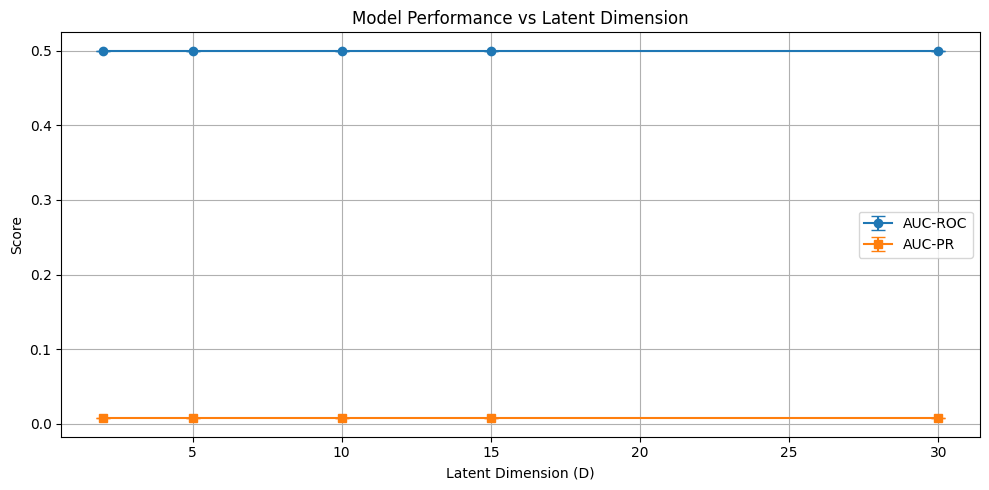

In [14]:
plot_auc(results, std_aucs, std_prs)

In [20]:
embedding_dims = [2, 5, 10, 15, 30]
holdout_ratio = 0.1
n_epochs = 300
lr = 0.001
results, std_NMIs = test_embedding_dims(Aij_real, embedding_dims, device, holdout_ratio, n_epochs, lr)

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/1000, Loss: 0.0901
Epoch 1/1000, Loss: 0.0888
Epoch 2/1000, Loss: 0.0880
Epoch 3/1000, Loss: 0.0873
Epoch 4/1000, Loss: 0.0868
Epoch 5/1000, Loss: 0.0860
Epoch 6/1000, Loss: 0.0854
Epoch 7/1000, Loss: 0.0848
Epoch 8/1000, Loss: 0.0843
Epoch 9/1000, Loss: 0.0840
Epoch 10/1000, Loss: 0.0837
Epoch 11/1000, Loss: 0.0835
Epoch 12/1000, Loss: 0.0832
Epoch 13/1000, Loss: 0.0829
Epoch 14/1000, Loss: 0.0826
Epoch 15/1000, Loss: 0.0824
Epoch 16/1000, Loss: 0.0821
Epoch 17/1000, Loss: 0.0819
Epoch 18/1000, Loss: 0.0817
Epoch 19/1000, Loss: 0.0815
Epoch 20/1000, Loss: 0.0813
Epoch 21/1000, Loss: 0.0811
Epoch 22/1000, Loss: 0.0809
Epoch 23/1000, Loss: 0.0807
Epoch 24/1000, Loss: 0.0805
Epoch 25/1000, Loss: 0.0803
Epoch 26/1000, Loss: 0.0802
Epoch 27/1000, Loss: 0.0800
Epoch 28/1000, Loss: 0.0798
Epoch 29/1000, Loss: 0.0796
Epoch 30/1000, Loss: 0.0794
Epoch 31/1000, Loss: 0.0792
Epoch 32/1000, Loss: 0.0790
Epoch 33/1000, Loss: 0.0788
Epoch 34/1000, Loss: 0.0787
Epoch 35/1000, Loss: 0.0785
Ep

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [9]:
embedding_dim = 15
n_epochs = 300
lr = 0.001
seed = 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed)
probit_output, latent_var1 = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/300, Loss: 3.5310
Epoch 1/300, Loss: 3.4891
Epoch 2/300, Loss: 3.4480
Epoch 3/300, Loss: 3.4076
Epoch 4/300, Loss: 3.3679
Epoch 5/300, Loss: 3.3291
Epoch 6/300, Loss: 3.2914
Epoch 7/300, Loss: 3.2546
Epoch 8/300, Loss: 3.2188
Epoch 9/300, Loss: 3.1833
Epoch 10/300, Loss: 3.1480
Epoch 11/300, Loss: 3.1121
Epoch 12/300, Loss: 3.0756
Epoch 13/300, Loss: 3.0392
Epoch 14/300, Loss: 3.0032
Epoch 15/300, Loss: 2.9678
Epoch 16/300, Loss: 2.9329
Epoch 17/300, Loss: 2.8986
Epoch 18/300, Loss: 2.8648
Epoch 19/300, Loss: 2.8311
Epoch 20/300, Loss: 2.7969
Epoch 21/300, Loss: 2.7618
Epoch 22/300, Loss: 2.7258
Epoch 23/300, Loss: 2.6900
Epoch 24/300, Loss: 2.6543
Epoch 25/300, Loss: 2.6184
Epoch 26/300, Loss: 2.5822
Epoch 27/300, Loss: 2.5466
Epoch 28/300, Loss: 2.5123
Epoch 29/300, Loss: 2.4799
Epoch 30/300, Loss: 2.4494
Epoch 31/300, Loss: 2.4204
Epoch 32/300, Loss: 2.3926
Epoch 33/300, Loss: 2.3655
Epoch 34/300, Loss: 2.3389
Epoch 35/300, Loss: 2.3121
Epoch 36/300, Loss: 2.2852
Epoch 37/30

In [57]:
latent_var1.shape

(745, 3677)

#### Statistical test for positions on the real line

In [58]:
from scipy.stats import kruskal, spearmanr, kendalltau
if hasattr(latent_var1, 'detach'):
    latent_var1 = latent_var1.detach().cpu().numpy()

if hasattr(Aij_real, 'detach'):
    Aij_real_np = Aij_real.detach().cpu().numpy()
else:
    Aij_real_np = Aij_real
latent_var1 = latent_var1.flatten()
true_labels = Aij_real_np.flatten()
rho, p_s = spearmanr(latent_var1, true_labels)
print(f"Spearman ρ = {rho:.4f}, p = {p_s:.4g}")

Spearman ρ = -0.0326, p = 0


In [59]:
groups = [latent_var1[true_labels == k] for k in range(4)]
H_stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis H = {H_stat:.4f}, p = {p_value:.4g}")


Kruskal-Wallis H = 2927.5704, p = 0


In [52]:
thresholds1 = model.get_thresholds()

In [72]:
latent_var1

array([-43.54199 , -43.625618, -44.365025, ...,  25.356085,  24.336887,
        26.92392 ], shape=(2739365,), dtype=float32)

In [92]:
def predict_from_latents(latents, thresholds):
    t0, t1, t2 = thresholds[:3]
    preds = np.zeros_like(latents, dtype=int)
    preds[(latents > t0) & (latents <= t1)] = 1
    preds[(latents > t1) & (latents <= t2)] = 2
    preds[latents > t2] = 3
    return preds
predicted_labels = predict_from_latents(latent_var1, thresholds1)

print(confusion_matrix(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels, digits=3))

[[      0 2085900   19920  580004]
 [      0   15587     118    4282]
 [      0    7218      63    3073]
 [      0   17190     136    5874]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000   2685824
         1.0      0.007     0.780     0.015     19987
         2.0      0.003     0.006     0.004     10354
         3.0      0.010     0.253     0.019     23200

    accuracy                          0.008   2739365
   macro avg      0.005     0.260     0.009   2739365
weighted avg      0.000     0.008     0.000   2739365



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [78]:
def map_latent_to_categories(latent_var, thresholds):
    """
    Maps continuous latent values to ordinal categories using learned thresholds.

    Args:
        latent_var (torch.Tensor): Tensor of shape (...), e.g., (n_drugs, n_effects)
        thresholds (torch.Tensor): 1D tensor of shape (n_classes + 1,) including -inf and +inf

    Returns:
        torch.Tensor: Tensor of same shape as latent_var with ordinal class indices (0 to n_classes - 1)
    """
    # Ensure latent_var and thresholds are on the same device
    latent_var = latent_var.to(thresholds.device)

    # Use broadcasting to compare latent_var against intervals
    category_indices = torch.sum(latent_var.unsqueeze(-1) >= thresholds[:-1], dim=-1) - 1

    return category_indices


In [81]:
#Investigating classification based on thresholds
probit_output, latent_var = model.probit() 
latent_var = latent_var.cpu()
thresholds = model.get_thresholds().cpu()  # shape: (n_classes + 1,)

mapped_classes = map_latent_to_categories(latent_var, thresholds)

# Now you can evaluate how well they align with true ordinal categories
true_classes = Aij_real.long().cpu()
pred_classes = mapped_classes.reshape(-1)
true_flat = true_classes.reshape(-1)

from sklearn.metrics import classification_report
print(classification_report(true_flat, pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98   2685824
           1       0.00      0.00      0.00     19987
           2       0.00      0.00      0.00     10354
           3       0.01      0.01      0.01     23200

    accuracy                           0.96   2739365
   macro avg       0.25      0.25      0.25   2739365
weighted avg       0.96      0.96      0.96   2739365



In [82]:
latent_flat = latent_var.detach().cpu().reshape(-1).numpy()
true_flat = Aij_real.detach().cpu().reshape(-1).numpy()

# Run the Spearman correlation test
rho, p_value = spearmanr(latent_flat, true_flat)

print(f"Spearman correlation: ρ = {rho:.4f}, p = {p_value:.2e}")

Spearman correlation: ρ = -0.1046, p = 0.00e+00


In [16]:
embedding_dim = 15
n_epochs = 300
lr = 0.09
seed = 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed)
probit_output, latent_var1 = model.probit() 
thresholds2 = model.get_thresholds()
loss_out = model.train() 

Epoch 0/300, Loss: 3.5310
Epoch 1/300, Loss: 1.2407
Epoch 2/300, Loss: 0.6195
Epoch 3/300, Loss: 0.4669
Epoch 4/300, Loss: 0.4110
Epoch 5/300, Loss: 0.3878
Epoch 6/300, Loss: 0.3833
Epoch 7/300, Loss: 0.3801
Epoch 8/300, Loss: 0.3756
Epoch 9/300, Loss: 0.3712
Epoch 10/300, Loss: 0.3674
Epoch 11/300, Loss: 0.3646
Epoch 12/300, Loss: 0.3626
Epoch 13/300, Loss: 0.3614
Epoch 14/300, Loss: 0.3607
Epoch 15/300, Loss: 0.3603
Epoch 16/300, Loss: 0.3601
Epoch 17/300, Loss: 0.3600
Epoch 18/300, Loss: 0.3600
Epoch 19/300, Loss: 0.3600
Epoch 20/300, Loss: 0.3600
Epoch 21/300, Loss: 0.3600
Epoch 22/300, Loss: 0.3600
Epoch 23/300, Loss: 0.3600
Epoch 24/300, Loss: 0.3600
Epoch 25/300, Loss: 0.3600
Epoch 26/300, Loss: 0.3600
Epoch 27/300, Loss: 0.3600
Epoch 28/300, Loss: 0.3600
Epoch 29/300, Loss: 0.3600
Epoch 30/300, Loss: 0.3600
Epoch 31/300, Loss: 0.3600
Epoch 32/300, Loss: 0.3599
Epoch 33/300, Loss: 0.3599
Epoch 34/300, Loss: 0.3599
Epoch 35/300, Loss: 0.3599
Epoch 36/300, Loss: 0.3599
Epoch 37/30

In [12]:
# Comparing the output of the probit output to the output from classifying based on thresholds
probit_matrix, latent = model.probit()
latent_vals = latent_var1.detach().cpu().numpy().flatten()
true_labels = model.Aij.detach().cpu().numpy().flatten()

rho, pval = spearmanr(latent_vals, true_labels)
print(f"Spearman correlation: ρ = {rho:.4f}, p = {pval:.4e}")


Spearman correlation: ρ = -0.0326, p = 0.0000e+00


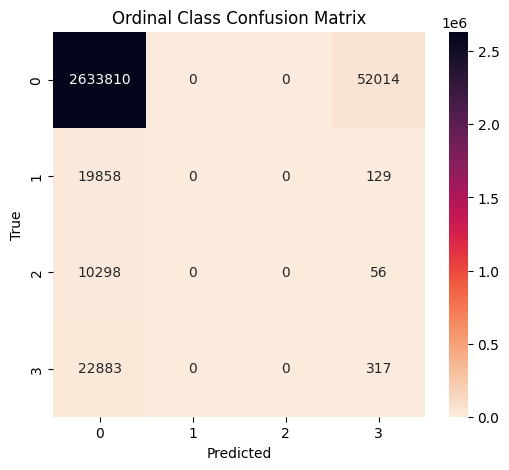


Classification Report:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0      0.980     0.981     0.980   2685824
           1      0.000     0.000     0.000     19987
           2      0.000     0.000     0.000     10354
           3      0.006     0.014     0.008     23200

    accuracy                          0.962   2739365
   macro avg      0.247     0.249     0.247   2739365
weighted avg      0.961     0.962     0.961   2739365

Accuracy per class:
Class 0: 0.981
Class 1: 0.000
Class 2: 0.000
Class 3: 0.014


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
evaluator = ModelEvaluate(model, Aij_real)
evaluator.plot_confusion()

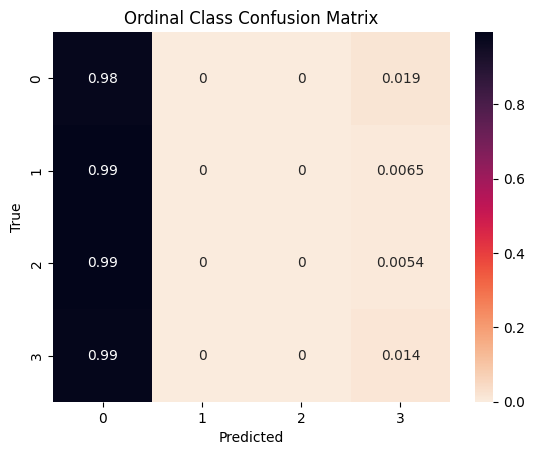

In [14]:
evaluator.plot_confusion_percent()

## Training Multiple Models

In [33]:
embedding_dim = 5
n_epochs =300
lr = 0.01
seed1 = 20

model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train() 

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/300, Loss: 4.1077
Epoch 1/300, Loss: 4.0572
Epoch 2/300, Loss: 4.0084
Epoch 3/300, Loss: 3.9617
Epoch 4/300, Loss: 3.9172
Epoch 5/300, Loss: 3.8748
Epoch 6/300, Loss: 3.8340
Epoch 7/300, Loss: 3.7944
Epoch 8/300, Loss: 3.7554
Epoch 9/300, Loss: 3.7165
Epoch 10/300, Loss: 3.6776
Epoch 11/300, Loss: 3.6385
Epoch 12/300, Loss: 3.5988
Epoch 13/300, Loss: 3.5583
Epoch 14/300, Loss: 3.5170
Epoch 15/300, Loss: 3.4759
Epoch 16/300, Loss: 3.4351
Epoch 17/300, Loss: 3.3947
Epoch 18/300, Loss: 3.3549
Epoch 19/300, Loss: 3.3159
Epoch 20/300, Loss: 3.2775
Epoch 21/300, Loss: 3.2395
Epoch 22/300, Loss: 3.2007
Epoch 23/300, Loss: 3.1606
Epoch 24/300, Loss: 3.1197
Epoch 25/300, Loss: 3.0785
Epoch 26/300, Loss: 3.0368
Epoch 27/300, Loss: 2.9945
Epoch 28/300, Loss: 2.9526
Epoch 29/300, Loss: 2.9121
Epoch 30/300, Loss: 2.8735
Epoch 31/300, Loss: 2.8365
Epoch 32/300, Loss: 2.8005
Epoch 33/300, Loss: 2.7652
Epoch 34/300, Loss: 2.7300
Epoch 35/300, Loss: 2.6952
Epoch 36/300, Loss: 2.6609
Epoch 37/30

In [44]:
probit_preds, _ = model.predict_categories()

In [46]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

# Binary correct/incorrect for each sample
real_correct = (probit_preds == true_labels).numpy()
baseline_correct = (baseline_preds == true_labels).numpy()

b = np.sum((real_correct == 1) & (baseline_correct == 0))
c = np.sum((real_correct == 0) & (baseline_correct == 1))

table = [[0, b], [c, 0]]

result = mcnemar(table, exact=True)
print(f"McNemar's test p-value: {result.pvalue:.4f}")


McNemar’s test p-value: 0.0000


### Testing NMI between different models with different settings

In [87]:
embedding_dim = 15
n_epochs =300
lr = 0.01
seed1 = 20
seed2 = 42

model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output, _ = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

model2 = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed2)
probit_output2, _ = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()  # Compute the ordinal cross-entropy loss

Epoch 0/300, Loss: 3.5310
Epoch 1/300, Loss: 3.1466
Epoch 2/300, Loss: 2.7981
Epoch 3/300, Loss: 2.4501
Epoch 4/300, Loss: 2.1753
Epoch 5/300, Loss: 1.9290
Epoch 6/300, Loss: 1.7561
Epoch 7/300, Loss: 1.5863
Epoch 8/300, Loss: 1.4130
Epoch 9/300, Loss: 1.2754
Epoch 10/300, Loss: 1.1588
Epoch 11/300, Loss: 1.0558
Epoch 12/300, Loss: 0.9664
Epoch 13/300, Loss: 0.9040
Epoch 14/300, Loss: 0.8458
Epoch 15/300, Loss: 0.7887
Epoch 16/300, Loss: 0.7384
Epoch 17/300, Loss: 0.6979
Epoch 18/300, Loss: 0.6663
Epoch 19/300, Loss: 0.6419
Epoch 20/300, Loss: 0.6231
Epoch 21/300, Loss: 0.6084
Epoch 22/300, Loss: 0.5961
Epoch 23/300, Loss: 0.5845
Epoch 24/300, Loss: 0.5728
Epoch 25/300, Loss: 0.5607
Epoch 26/300, Loss: 0.5486
Epoch 27/300, Loss: 0.5372
Epoch 28/300, Loss: 0.5267
Epoch 29/300, Loss: 0.5172
Epoch 30/300, Loss: 0.5087
Epoch 31/300, Loss: 0.5006
Epoch 32/300, Loss: 0.4924
Epoch 33/300, Loss: 0.4832
Epoch 34/300, Loss: 0.4739
Epoch 35/300, Loss: 0.4657
Epoch 36/300, Loss: 0.4590
Epoch 37/30

In [91]:
NMI, joint_probs = NMI_advanced(probit_output, probit_output2)
NMI, joint_probs

(np.float64(0.022031639269514448),
 array([[3.04778062e-01, 7.46780494e-03, 6.92131898e-03, 4.24326757e-01],
        [8.93722395e-04, 4.11696976e-05, 3.80795799e-05, 1.31768109e-03],
        [2.97575110e-04, 1.39146661e-05, 1.28879513e-05, 4.43448869e-04],
        [5.68333349e-02, 3.58318049e-03, 3.46310797e-03, 1.89567955e-01]]))

#### Learning rate change

In [43]:
embedding_dim = 2
n_epochs =100
lr = 0.05
seed1 = 20
seed2 = 42

#Training model with seed 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

#Training model with seed 42
model2 = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed2)
probit_output2 = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()

#Computing NMI
NMI, joint_probs = NMI_advanced(probit_output, probit_output2)
NMI, joint_probs

(np.float64(0.8922120506674133),
 array([[1.70109192e-01, 9.42904848e-03, 1.33388967e-03, 1.31684167e-03],
        [8.40910554e-04, 6.96472691e-05, 1.00066097e-05, 9.90926344e-06],
        [8.06955502e-04, 6.70641756e-05, 9.63952520e-06, 9.54675912e-06],
        [1.61154455e-03, 1.34558625e-04, 1.93529381e-05, 1.91697295e-05]]))

In [42]:
#Variables
embedding_dim = 2
n_epochs =100
lr = 0.005
seed1 = 20
seed2 = 42

#Training model with seed 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

#Training model with seed 42
model2 = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed2)
probit_output2 = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()

#Computing NMI
NMI, joint_probs = NMI_advanced(probit_output, probit_output2)
NMI, joint_probs

(np.float64(0.8922120506674133),
 array([[1.70109192e-01, 9.42904848e-03, 1.33388967e-03, 1.31684167e-03],
        [8.40910554e-04, 6.96472691e-05, 1.00066097e-05, 9.90926344e-06],
        [8.06955502e-04, 6.70641756e-05, 9.63952520e-06, 9.54675912e-06],
        [1.61154455e-03, 1.34558625e-04, 1.93529381e-05, 1.91697295e-05]]))

In [110]:
#Variables
embedding_dim = 15
n_epochs =100
lr = 0.001
seed1 = 20
seed2 = 42

#Training model with seed 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output, _ = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

#Training model with seed 42
model2 = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed2)
probit_output2, _ = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()

#Computing NMI
NMI1, joint_probs1 = NMI_advanced(probit_output, probit_output2)
NMI1, joint_probs1

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/100, Loss: 3.5310
Epoch 1/100, Loss: 3.4891
Epoch 2/100, Loss: 3.4480
Epoch 3/100, Loss: 3.4076
Epoch 4/100, Loss: 3.3679
Epoch 5/100, Loss: 3.3291
Epoch 6/100, Loss: 3.2914
Epoch 7/100, Loss: 3.2546
Epoch 8/100, Loss: 3.2188
Epoch 9/100, Loss: 3.1833
Epoch 10/100, Loss: 3.1480
Epoch 11/100, Loss: 3.1121
Epoch 12/100, Loss: 3.0756
Epoch 13/100, Loss: 3.0392
Epoch 14/100, Loss: 3.0032
Epoch 15/100, Loss: 2.9678
Epoch 16/100, Loss: 2.9329
Epoch 17/100, Loss: 2.8986
Epoch 18/100, Loss: 2.8648
Epoch 19/100, Loss: 2.8311
Epoch 20/100, Loss: 2.7969
Epoch 21/100, Loss: 2.7618
Epoch 22/100, Loss: 2.7258
Epoch 23/100, Loss: 2.6900
Epoch 24/100, Loss: 2.6543
Epoch 25/100, Loss: 2.6184
Epoch 26/100, Loss: 2.5822
Epoch 27/100, Loss: 2.5466
Epoch 28/100, Loss: 2.5123
Epoch 29/100, Loss: 2.4799
Epoch 30/100, Loss: 2.4494
Epoch 31/100, Loss: 2.4204
Epoch 32/100, Loss: 2.3926
Epoch 33/100, Loss: 2.3655
Epoch 34/100, Loss: 2.3389
Epoch 35/100, Loss: 2.3121
Epoch 36/100, Loss: 2.2852
Epoch 37/10

(np.float64(0.022031639269514448),
 array([[3.04778062e-01, 7.46780494e-03, 6.92131898e-03, 4.24326757e-01],
        [8.93722395e-04, 4.11696976e-05, 3.80795799e-05, 1.31768109e-03],
        [2.97575110e-04, 1.39146661e-05, 1.28879513e-05, 4.43448869e-04],
        [5.68333349e-02, 3.58318049e-03, 3.46310797e-03, 1.89567955e-01]]))

In [107]:
#Variables
embedding_dim = 15
n_epochs =500
lr = 0.001
seed1 = 20
seed2 = 42

#Training model with seed 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output, _ = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

#Training model with seed 42
model2 = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed2)
probit_output2, _ = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()

#Computing NMI
NMI2, joint_probs2 = NMI_advanced(probit_output, probit_output2)
NMI2, joint_probs2

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/500, Loss: 3.5310
Epoch 1/500, Loss: 3.4891
Epoch 2/500, Loss: 3.4480
Epoch 3/500, Loss: 3.4076
Epoch 4/500, Loss: 3.3679
Epoch 5/500, Loss: 3.3291
Epoch 6/500, Loss: 3.2914
Epoch 7/500, Loss: 3.2546
Epoch 8/500, Loss: 3.2188
Epoch 9/500, Loss: 3.1833
Epoch 10/500, Loss: 3.1480
Epoch 11/500, Loss: 3.1121
Epoch 12/500, Loss: 3.0756
Epoch 13/500, Loss: 3.0392
Epoch 14/500, Loss: 3.0032
Epoch 15/500, Loss: 2.9678
Epoch 16/500, Loss: 2.9329
Epoch 17/500, Loss: 2.8986
Epoch 18/500, Loss: 2.8648
Epoch 19/500, Loss: 2.8311
Epoch 20/500, Loss: 2.7969
Epoch 21/500, Loss: 2.7618
Epoch 22/500, Loss: 2.7258
Epoch 23/500, Loss: 2.6900
Epoch 24/500, Loss: 2.6543
Epoch 25/500, Loss: 2.6184
Epoch 26/500, Loss: 2.5822
Epoch 27/500, Loss: 2.5466
Epoch 28/500, Loss: 2.5123
Epoch 29/500, Loss: 2.4799
Epoch 30/500, Loss: 2.4494
Epoch 31/500, Loss: 2.4204
Epoch 32/500, Loss: 2.3926
Epoch 33/500, Loss: 2.3655
Epoch 34/500, Loss: 2.3389
Epoch 35/500, Loss: 2.3121
Epoch 36/500, Loss: 2.2852
Epoch 37/50

(np.float64(0.022031639269514448),
 array([[3.04778062e-01, 7.46780494e-03, 6.92131898e-03, 4.24326757e-01],
        [8.93722395e-04, 4.11696976e-05, 3.80795799e-05, 1.31768109e-03],
        [2.97575110e-04, 1.39146661e-05, 1.28879513e-05, 4.43448869e-04],
        [5.68333349e-02, 3.58318049e-03, 3.46310797e-03, 1.89567955e-01]]))

In [112]:
ttest_rel(NMI1, NMI2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1213: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1213: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.int64(0))

#### Testing NMI between two models

In [97]:
#Variables
embedding_dim = 5
n_epochs =500
lr = 0.01
seed1 = 20
seed2 = 42

#Training model with seed 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed1)
probit_output, _ = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

#Training model with seed 42
model2 = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed2)
probit_output2, _ = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()

#Computing NMI
NMI, joint_probs = NMI_advanced(probit_output, probit_output2)
NMI, joint_probs

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/500, Loss: 4.1077
Epoch 1/500, Loss: 3.7106
Epoch 2/500, Loss: 3.3540
Epoch 3/500, Loss: 2.9900
Epoch 4/500, Loss: 2.6582
Epoch 5/500, Loss: 2.3713
Epoch 6/500, Loss: 2.1316
Epoch 7/500, Loss: 1.9499
Epoch 8/500, Loss: 1.7567
Epoch 9/500, Loss: 1.5900
Epoch 10/500, Loss: 1.4443
Epoch 11/500, Loss: 1.3105
Epoch 12/500, Loss: 1.1874
Epoch 13/500, Loss: 1.0848
Epoch 14/500, Loss: 1.0037
Epoch 15/500, Loss: 0.9279
Epoch 16/500, Loss: 0.8614
Epoch 17/500, Loss: 0.8046
Epoch 18/500, Loss: 0.7554
Epoch 19/500, Loss: 0.7159
Epoch 20/500, Loss: 0.6857
Epoch 21/500, Loss: 0.6628
Epoch 22/500, Loss: 0.6448
Epoch 23/500, Loss: 0.6295
Epoch 24/500, Loss: 0.6152
Epoch 25/500, Loss: 0.6012
Epoch 26/500, Loss: 0.5878
Epoch 27/500, Loss: 0.5754
Epoch 28/500, Loss: 0.5641
Epoch 29/500, Loss: 0.5538
Epoch 30/500, Loss: 0.5442
Epoch 31/500, Loss: 0.5343
Epoch 32/500, Loss: 0.5239
Epoch 33/500, Loss: 0.5138
Epoch 34/500, Loss: 0.5051
Epoch 35/500, Loss: 0.4981
Epoch 36/500, Loss: 0.4928
Epoch 37/50

(np.float64(0.018737278851020986),
 array([[2.42194070e-01, 1.18370493e-03, 1.90252421e-03, 4.50624199e-01],
        [3.25362198e-03, 2.36242808e-05, 3.82324457e-05, 5.98405457e-03],
        [1.07240758e-03, 7.89582912e-06, 1.27948131e-05, 2.05073248e-03],
        [5.66503693e-02, 3.57975559e-04, 5.91891308e-04, 2.34051902e-01]]))

In [104]:
np.max(model.w.detach().cpu().numpy())

np.float32(4.301017)

In [90]:
evaluator = ModelEvaluate(model, Aij_real)
auc_roc, auc_pr = evaluator.evaluate_binary()
auc_roc, auc_pr

(np.float64(0.5000048707350917), np.float64(0.019545422590628324))

In [71]:
auc_roc, auc_pr = evaluator.evaluate_()
auc_roc, auc_pr

(np.float64(0.526428844322659), np.float64(0.009124956166759474))